In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/RL-Epidemic-Control/project

/content/drive/MyDrive/RL-Epidemic-Control/project


In [3]:
!pip install pytorch torchvision torchaudio
!pip install numpy networkx matplotlib pyyaml jupyter tqdm pandas
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
  error: subprocess-exited-with-error
  
  × Running setup.py install for pytorch did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Running setup.py install for pytorch ... error
error: legacy-install-failure

× Encountered error while trying to install package.
╰─> pytorch

note: This is an issue with the package mentioned above, not pip.
hint: See above for output from the failure.
Looking in indexes: ht

In [1]:
# provided packages
from epidemic_env.dynamics import *
from epidemic_env.env import *
from epidemic_env.agent import *
from epidemic_env.visualize import *

# our packages
from env_preprocessors import *
from training import *
from models import *
from utils import *

# libraries
from gym import spaces

import numpy as np
import torch

# set up matplotlib
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

In [3]:
# model dynamics
dyn = ModelDynamics('config/switzerland.yaml')

# PART 1

In [ ]:
# dummy environment: no need for an action space or an observation space
env1 = Env(dyn)
env1.reset(SEED);

In [ ]:
# dummy simulation: the same action is taken throughout the simulation
def single_action_simulation_log(env, action, n_episodes=1):
    # logs
    logs = []
    
    # episodes
    for ep_num in range(n_episodes):
        # reset the environment
        env.reset(SEED)
        
        logs.append([])
        
        # start of episode
        finished_epoch = False
        while not finished_epoch:
            _, _, finished_epoch, info = env.step(action)
            logs[ep_num].append(info)
    return logs

In [ ]:
IDLE_ACTION

{'confinement': False,
 'isolation': False,
 'hospital': False,
 'vaccinate': False}

In [ ]:
logs = single_action_simulation_log(env1, action=IDLE_ACTION)
log = logs[0]

In [ ]:
health_states = HEALTH_STATES_CMAP.keys()
health_states

dict_keys(['exposed', 'infected', 'dead', 'suceptible', 'recovered'])

In [ ]:
# idle epoch dict of total population per health state
idle_epoch_totals = extract_totals(log, health_states=health_states)

# idle epoch dict of city total population per health state
idle_epoch_city_totals = extract_city_totals(log, health_states=HEALTH_STATES_CMAP.keys(), cities=dyn.cities)

### Question 1

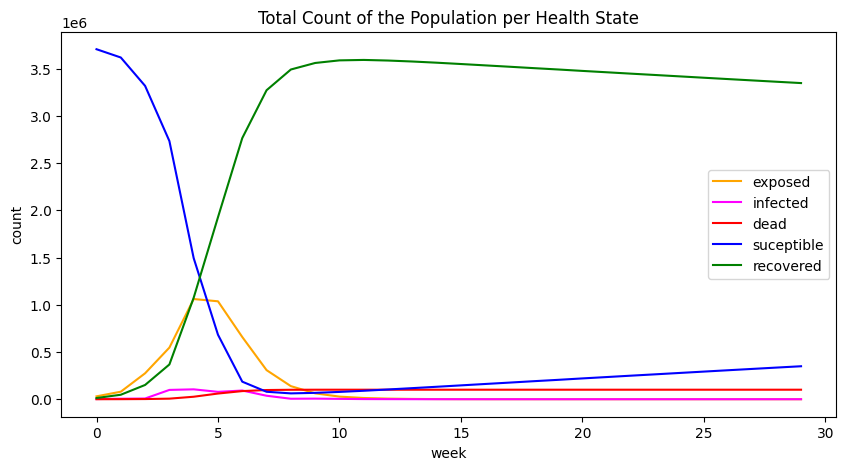

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))

for state, totals in idle_epoch_totals.items():
    ax.plot(totals, label=state, color=HEALTH_STATES_CMAP[state])
ax.set_title("Total Count of the Population per Health State")
ax.set_xlabel("week")
ax.set_ylabel("count")
ax.legend();

**Discussion**

With an idle (do-nothing) policy, the number of `suceptible` people decreases at first, either because they are infected or because they recover since the number of  `recovered` or `infected` people increases through most of the first third (10 first weeks). In the last third, the number of `suceptible` people increases because the `recovered` people become once again `suceptible`, even if the epidemic seems to have been stopped by then since the number of `exposed` or `infected` are stagnant at zero in that period. There seem to be a strong correlation between `infected` and `exposed`, which we expect under this policy since the more people are infected the more will be exposed. There is also a strong correlation at first between `infected` and `dead` explained by the fact that the more infected people the more people are suceptible to die, but `infected` and `dead` become decorrelated around the end of the first third.

### Question 2

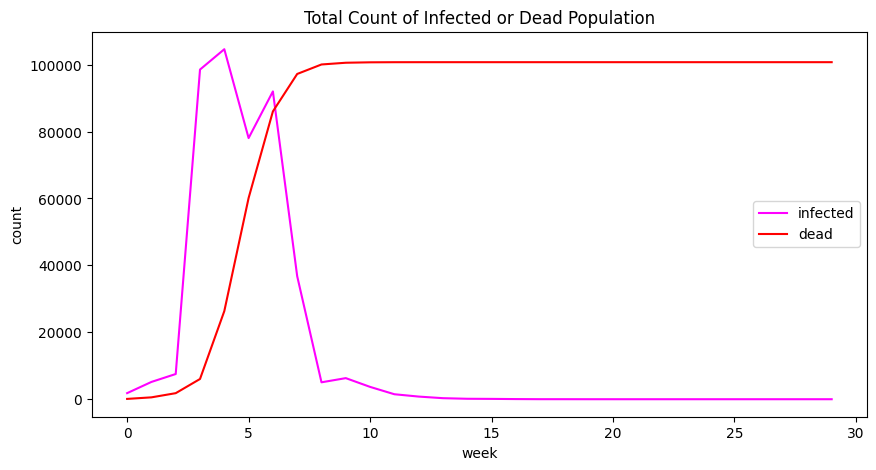

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))

for state in ["infected", "dead"]:
    ax.plot(idle_epoch_totals[state], label=state, color=HEALTH_STATES_CMAP[state])
ax.set_title("Total Count of Infected or Dead Population")
ax.set_xlabel("week")
ax.set_ylabel("count")
ax.legend();

**Discussion**

This plot confirms (since it has a better visualization) the explanations in the previous discussion regarding the correlation between `infected` and `dead` under the do-nothing policy. Moreover, we notice that the number of `infected` fluctuates in the middle of its peak, which may be caused by the increase in deaths and recoveries which prevent the agents (the sick people) from transmitting the disease.

### Question 3

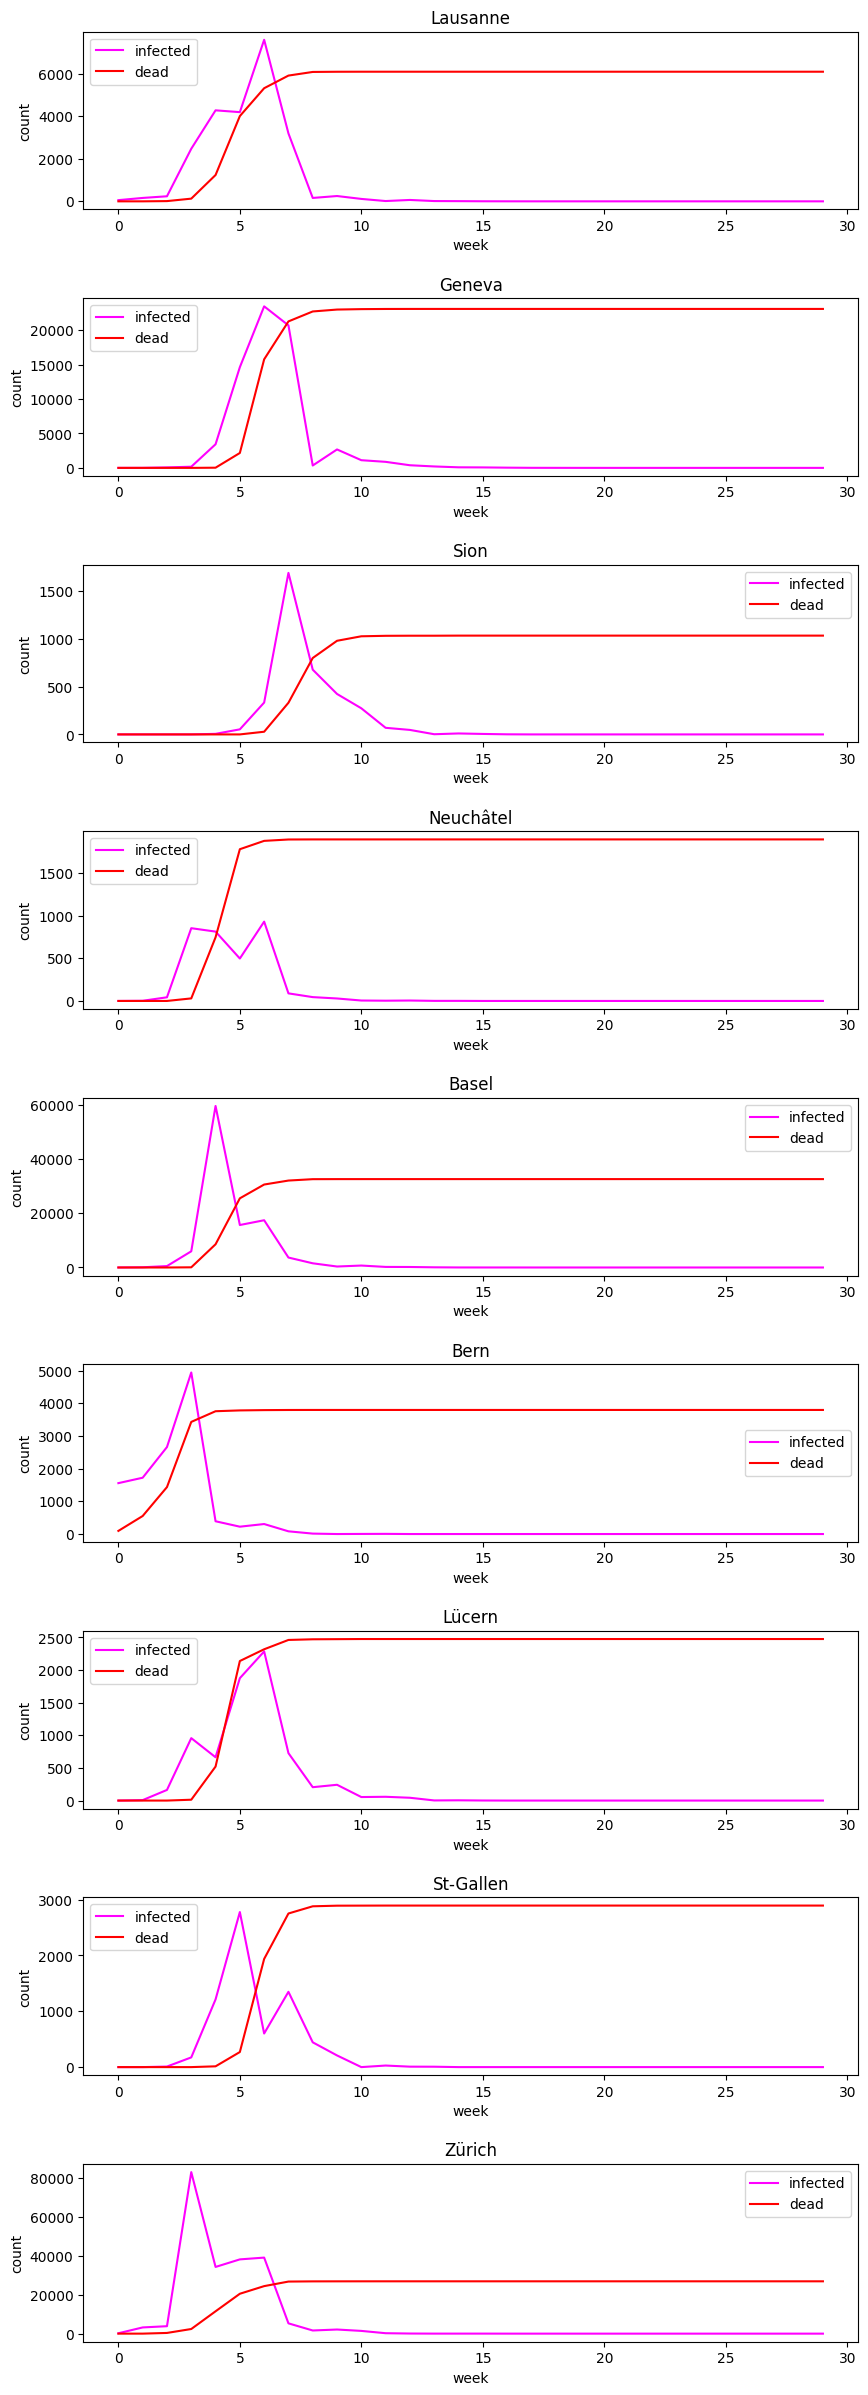

In [ ]:
fig, axs = plt.subplots(9, 1, figsize=(10, 30))
fig.subplots_adjust(hspace=0.5)

for city_name, ax in zip(dyn.cities, axs):
    for state in ["infected", "dead"]:
        ax.plot(idle_epoch_city_totals[city_name][state], label=state, color=HEALTH_STATES_CMAP[state])
        ax.set_title(f"{city_name}")
        ax.set_xlabel("week")
        ax.set_ylabel("count")
        ax.legend()

**Discussion**

The relationship between `infected` and `dead` has been pointed out in the previous couple of discussions. Moreover, we notice that the number of infections and deaths in Zürich and Basel are much larger than in the other cities. In fact, the epidemic started in Zûrich because it is the only city with a non-null number of infections at the end of the first week. Since the two cities are strongly connected and have the highest populations, the epidemic quickly spread to Basel.

# PART 2

### Question 2.a

In [ ]:
env2 = Env(dyn,
           action_preprocessor=russo_acton_preprocessor, 
           observation_preprocessor=russo_observation_preprocessor)

russo_agent = RussoAgent(env2, confinement_duration=4)

logs = russo_agent.eval_model(n_episodes=1).logs
log = logs[0]

**Question 2.a.1**

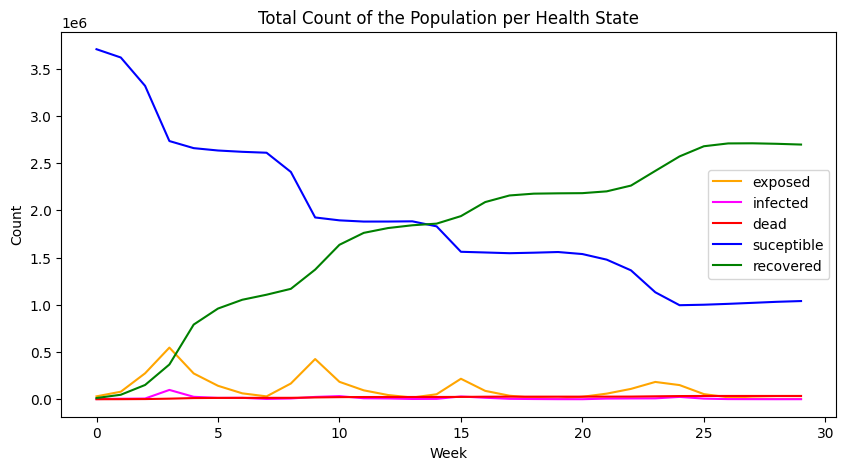

In [ ]:
episode_totals_plot(log)

**Question 2.a.2**

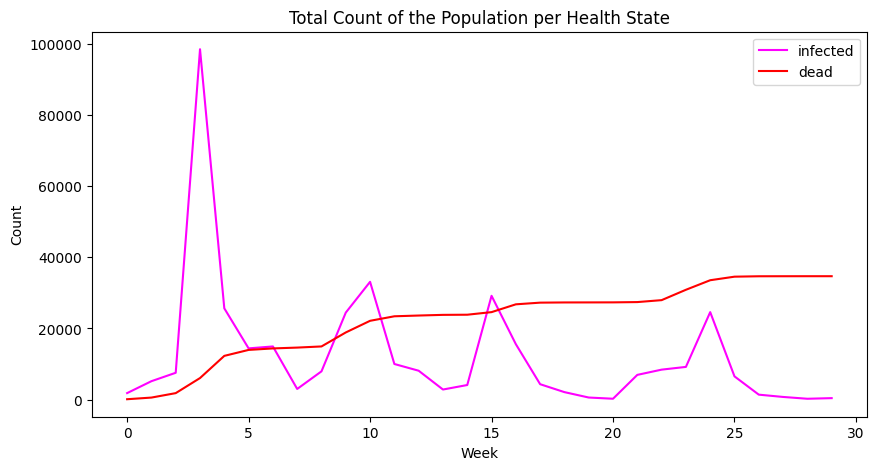

In [ ]:
episode_totals_plot(log, health_states=["infected", "dead"])

**Question 2.a.3**

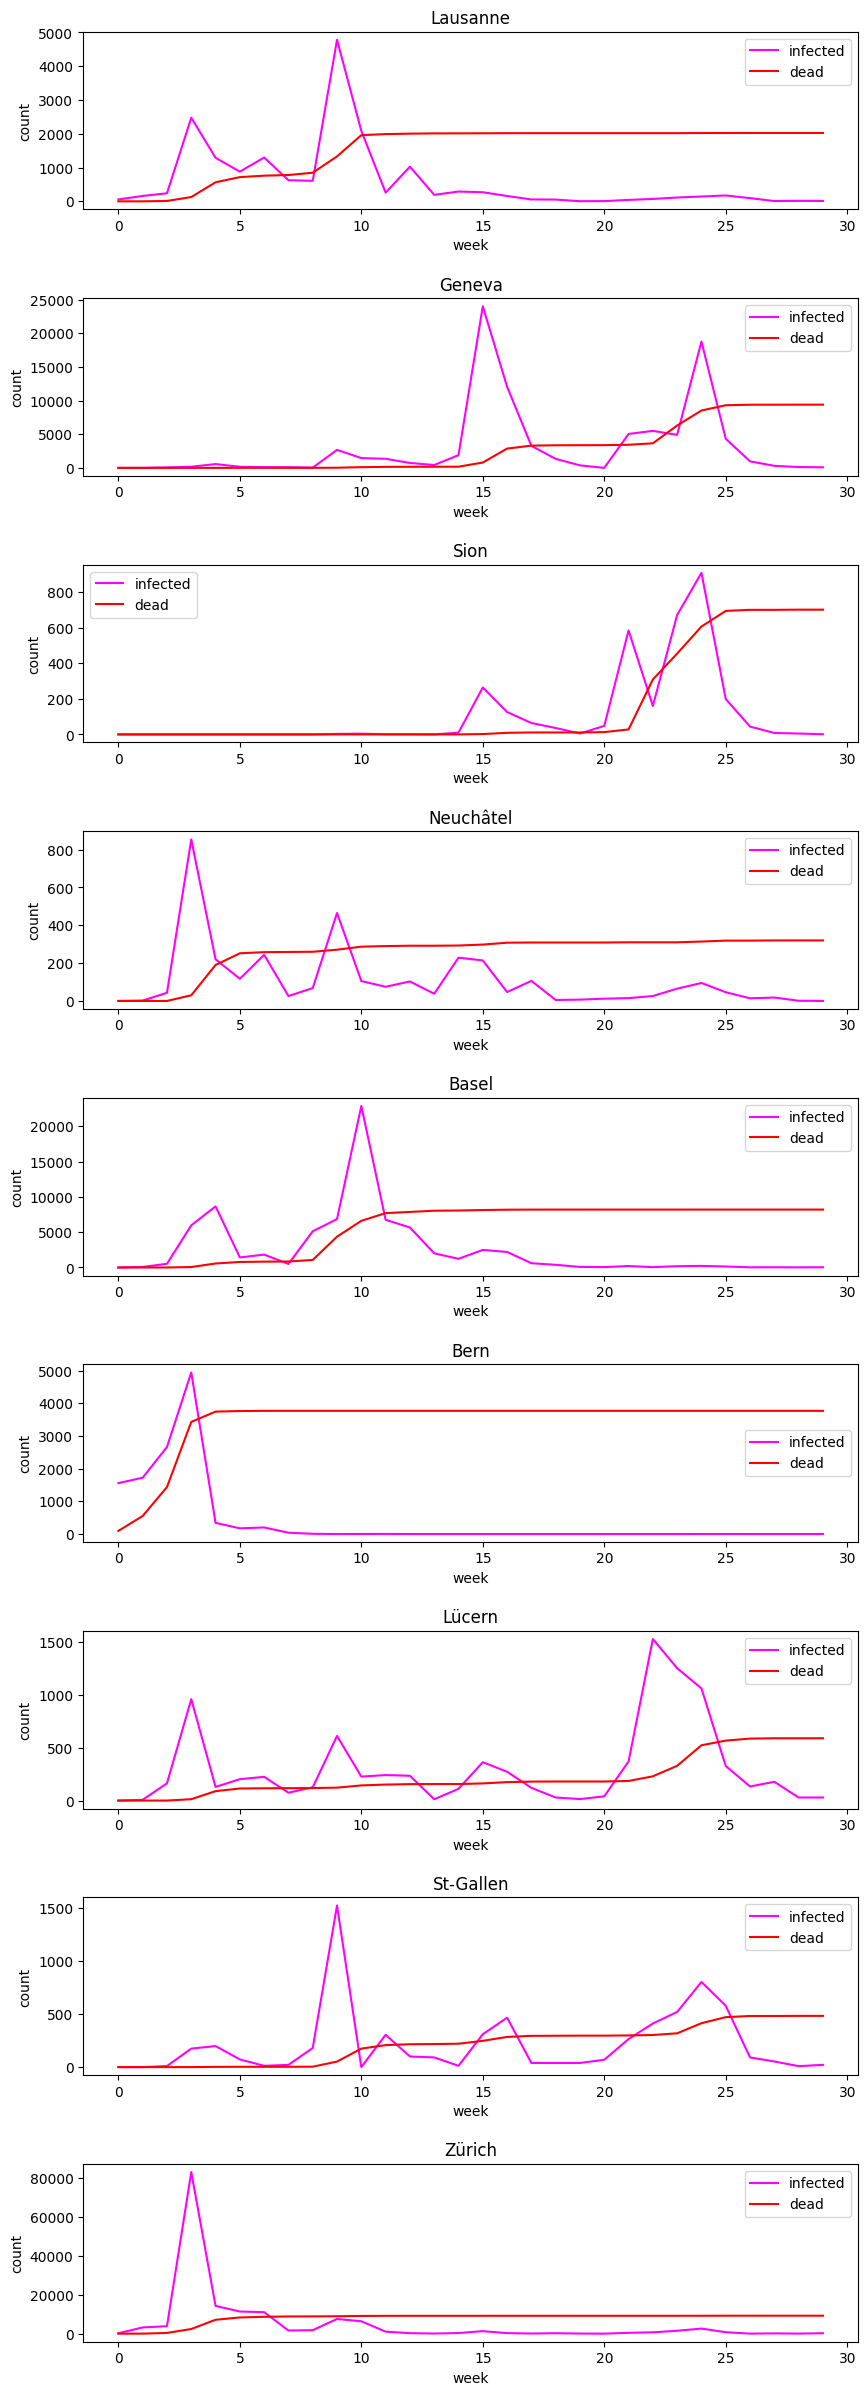

In [ ]:
episode_city_totals_plot(log, health_states=["infected", "dead"], cities=dyn.cities)

**Question 2.a.4**

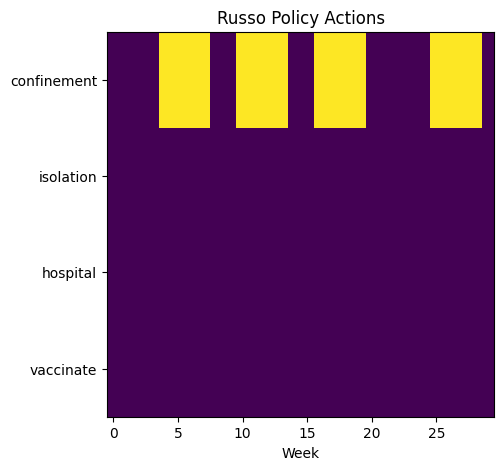

In [ ]:
episode_actions_plot(log, actions=ACTIONS, title="Russo Policy Actions")

**Discussion**

- __Reaction of the epidemic to the policy__: It can be clearly seen from the plot of question (2.a.2) that the confinement periods heavily attenuate the number of infections and stagnate the deaths. Moreover, during the same periods, the number of `exposed` is attenuated, the number of `suceptible` stagnates and the number of `recovered` increases slightly.

- __Conclusion__: Unlike in the unmitigated case where the epidemic is extinguished solely by relying on the recoveries and (many) deaths, Russo's policy helps stop the epidemic with less deaths. In fact, thanks to the confinement periods and their effect described above, the final number of deaths is lower with Russo's policy across cities and in total, compared to the unmitigated case.

### Question 2.b

In [ ]:
eval_result = russo_agent.eval_model(n_episodes=50)

Average death number: 55443.66
Average number of confined days: 103.32
Average cumulative reward: -62.120918322524524


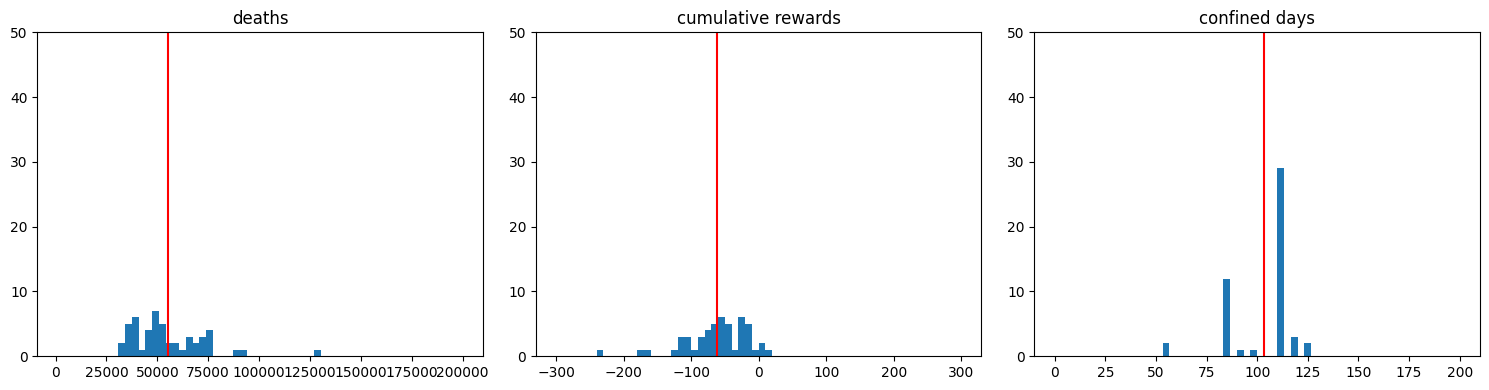

In [ ]:
fig, ax = plt.subplots(1, 3,figsize=(15, 4))

hist_avg(ax[0], eval_result.deaths,'deaths')
hist_avg(ax[1], eval_result.cum_rewards,'cumulative rewards')
hist_avg(ax[2], eval_result.confinement_days,'confined days')
fig.tight_layout()

print(f'Average death number: {np.mean(eval_result.deaths)}')
print(f'Average number of confined days: {np.mean(eval_result.confinement_days)}')
print(f'Average cumulative reward: {np.mean(eval_result.cum_rewards)}')

# PART 3

sampled action : 1
Sampled observation


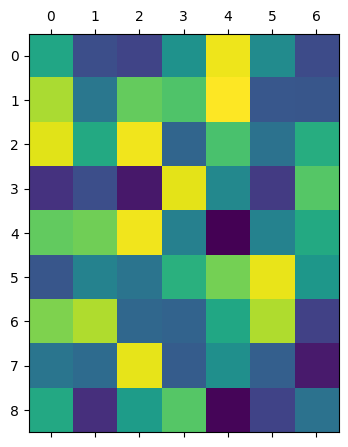

In [31]:
action_space      = spaces.Discrete(2) # [0, 1]
observation_space = spaces.Box(low=0, high=1,
                               shape=(2, dyn.n_cities, dyn.env_step_length),
                               dtype=np.float16)

print(f"sampled action : {action_space.sample()}")
print("Sampled observation")
plt.matshow(observation_space.sample()[0,:,:])
plt.show()

In [32]:
env3 = Env(dyn,
           action_space=action_space,
           observation_space=observation_space,
           action_preprocessor=dqn_action_preprocessor,
           observation_preprocessor=dqn_observation_preprocessor)

## 3.a)

In [33]:
savepaths = ["./train/DQN-base-{}.pt".format(model_number) for model_number in range(3)]
dqn_base_agents_results = []

for seed_i, savepath in enumerate(savepaths):
    agent = DQNAgent(env3)
    train_result = train(agent, savepath, n_episodes=1000)
    dqn_base_agents_results.append((agent, train_result))

  0%|          | 0/1000 [00:00<?, ?it/s]

mean reward:  -147.55367529513313
AGENT SAVED


  5%|▌         | 50/1000 [00:32<07:21,  2.15it/s] 

mean reward:  -147.55367529513313
AGENT SAVED


 10%|█         | 100/1000 [01:17<12:33,  1.19it/s]

mean reward:  35.552664102241394
AGENT SAVED


 15%|█▌        | 150/1000 [02:07<11:48,  1.20it/s]

mean reward:  38.42016840912402
AGENT SAVED


 20%|██        | 200/1000 [02:59<11:08,  1.20it/s]

mean reward:  42.92697133719921
AGENT SAVED


 25%|██▌       | 250/1000 [03:50<10:29,  1.19it/s]

mean reward:  41.43790601287037


 30%|███       | 300/1000 [04:43<10:02,  1.16it/s]

mean reward:  45.23822092600167
AGENT SAVED


 35%|███▌      | 350/1000 [05:37<09:49,  1.10it/s]

mean reward:  46.33798696957528
AGENT SAVED


 40%|████      | 400/1000 [06:30<08:36,  1.16it/s]

mean reward:  43.880774188786745


 45%|████▌     | 450/1000 [07:24<08:05,  1.13it/s]

mean reward:  44.242628327384594


 50%|█████     | 500/1000 [08:17<07:19,  1.14it/s]

mean reward:  44.21833609044552


 55%|█████▌    | 550/1000 [09:11<06:31,  1.15it/s]

mean reward:  43.677204666286706


 60%|██████    | 600/1000 [10:02<05:30,  1.21it/s]

mean reward:  42.466592172905806


 65%|██████▌   | 650/1000 [10:55<04:49,  1.21it/s]

mean reward:  45.28887499123812


 70%|███████   | 700/1000 [11:46<04:10,  1.20it/s]

mean reward:  40.89681703802198


 75%|███████▌  | 750/1000 [12:38<03:30,  1.19it/s]

mean reward:  44.59217922277749


 80%|████████  | 800/1000 [13:30<02:49,  1.18it/s]

mean reward:  37.99681013841182


 85%|████████▌ | 850/1000 [14:22<02:05,  1.19it/s]

mean reward:  45.008756244182585


 90%|█████████ | 900/1000 [15:14<01:24,  1.18it/s]

mean reward:  39.52758345939219


 95%|█████████▌| 950/1000 [16:07<00:42,  1.18it/s]

mean reward:  40.48733309153467


100%|██████████| 1000/1000 [17:00<00:00,  1.02s/it]


mean reward:  41.00918102189898


  0%|          | 0/1000 [00:00<?, ?it/s]

mean reward:  22.937940513342618
AGENT SAVED


  5%|▌         | 50/1000 [00:31<07:12,  2.20it/s] 

mean reward:  22.937940513342618
AGENT SAVED


 10%|█         | 100/1000 [01:14<12:05,  1.24it/s]

mean reward:  43.67925258614123
AGENT SAVED


 15%|█▌        | 150/1000 [02:04<11:30,  1.23it/s]

mean reward:  38.00872048921883


 20%|██        | 200/1000 [02:56<10:55,  1.22it/s]

mean reward:  40.14493445158005


 25%|██▌       | 250/1000 [03:47<10:22,  1.21it/s]

mean reward:  40.48547163903713


 30%|███       | 300/1000 [04:39<09:48,  1.19it/s]

mean reward:  46.09981280900538
AGENT SAVED


 35%|███▌      | 350/1000 [05:31<09:12,  1.18it/s]

mean reward:  46.6879195291549
AGENT SAVED


 40%|████      | 400/1000 [06:24<08:25,  1.19it/s]

mean reward:  41.23895982727409


 45%|████▌     | 450/1000 [07:16<07:55,  1.16it/s]

mean reward:  45.017193191871044


 50%|█████     | 500/1000 [08:09<07:15,  1.15it/s]

mean reward:  43.64574855975807


 55%|█████▌    | 550/1000 [09:02<06:40,  1.12it/s]

mean reward:  44.18238343633711


 60%|██████    | 600/1000 [09:56<06:09,  1.08it/s]

mean reward:  39.47559149339795


 65%|██████▌   | 650/1000 [10:49<05:06,  1.14it/s]

mean reward:  44.92301590405405


 70%|███████   | 700/1000 [11:41<04:19,  1.16it/s]

mean reward:  45.317847703024746


 75%|███████▌  | 750/1000 [12:36<03:36,  1.15it/s]

mean reward:  46.57670208550989


 80%|████████  | 800/1000 [13:29<02:57,  1.13it/s]

mean reward:  44.498932372406124


 85%|████████▌ | 850/1000 [14:24<02:13,  1.13it/s]

mean reward:  38.3140486381948


 90%|█████████ | 900/1000 [15:17<01:29,  1.12it/s]

mean reward:  40.32402775362134


 95%|█████████▌| 950/1000 [16:13<00:47,  1.06it/s]

mean reward:  43.716298477724195


100%|██████████| 1000/1000 [17:06<00:00,  1.03s/it]


mean reward:  44.242373790219425


  0%|          | 0/1000 [00:00<?, ?it/s]

mean reward:  -147.55367529513313
AGENT SAVED


  5%|▌         | 50/1000 [00:31<07:13,  2.19it/s] 

mean reward:  -147.55367529513313
AGENT SAVED


 10%|█         | 100/1000 [01:15<12:09,  1.23it/s]

mean reward:  37.87910408526659
AGENT SAVED


 15%|█▌        | 150/1000 [02:07<11:46,  1.20it/s]

mean reward:  36.200365159101786


 20%|██        | 200/1000 [02:58<11:15,  1.18it/s]

mean reward:  34.684350510686635


 25%|██▌       | 250/1000 [03:51<14:05,  1.13s/it]

mean reward:  32.42807187195867


 30%|███       | 300/1000 [04:43<09:59,  1.17it/s]

mean reward:  38.79681727774441
AGENT SAVED


 35%|███▌      | 350/1000 [05:35<09:22,  1.16it/s]

mean reward:  38.24486106224358


 40%|████      | 400/1000 [06:28<08:42,  1.15it/s]

mean reward:  33.21365262810141


 45%|████▌     | 450/1000 [07:20<08:06,  1.13it/s]

mean reward:  40.35347138457
AGENT SAVED


 50%|█████     | 500/1000 [08:11<07:06,  1.17it/s]

mean reward:  38.98437212686986


 55%|█████▌    | 550/1000 [09:05<06:26,  1.17it/s]

mean reward:  38.1207632239908


 60%|██████    | 600/1000 [09:58<05:45,  1.16it/s]

mean reward:  37.8727655749768


 65%|██████▌   | 650/1000 [10:52<05:15,  1.11it/s]

mean reward:  41.48384127505123
AGENT SAVED


 70%|███████   | 700/1000 [11:45<04:23,  1.14it/s]

mean reward:  40.26854853220284


 75%|███████▌  | 750/1000 [12:38<03:37,  1.15it/s]

mean reward:  40.8932689987123


 80%|████████  | 800/1000 [13:33<02:56,  1.13it/s]

mean reward:  43.33693669959903
AGENT SAVED


 85%|████████▌ | 850/1000 [14:26<02:12,  1.14it/s]

mean reward:  39.66257341690361


 90%|█████████ | 900/1000 [15:19<01:27,  1.14it/s]

mean reward:  39.301571586728095


 95%|█████████▌| 950/1000 [16:13<00:43,  1.15it/s]

mean reward:  38.7029582131654


100%|██████████| 1000/1000 [17:06<00:00,  1.03s/it]


mean reward:  40.46383642666042


In [35]:
dqn_base_agents = list(map(lambda x: x[0], dqn_base_agents_results))
train_traces, eval_traces = zip(*list(map(lambda item: (item[1].train_trace, item[1].eval_trace), dqn_base_agents_results)))

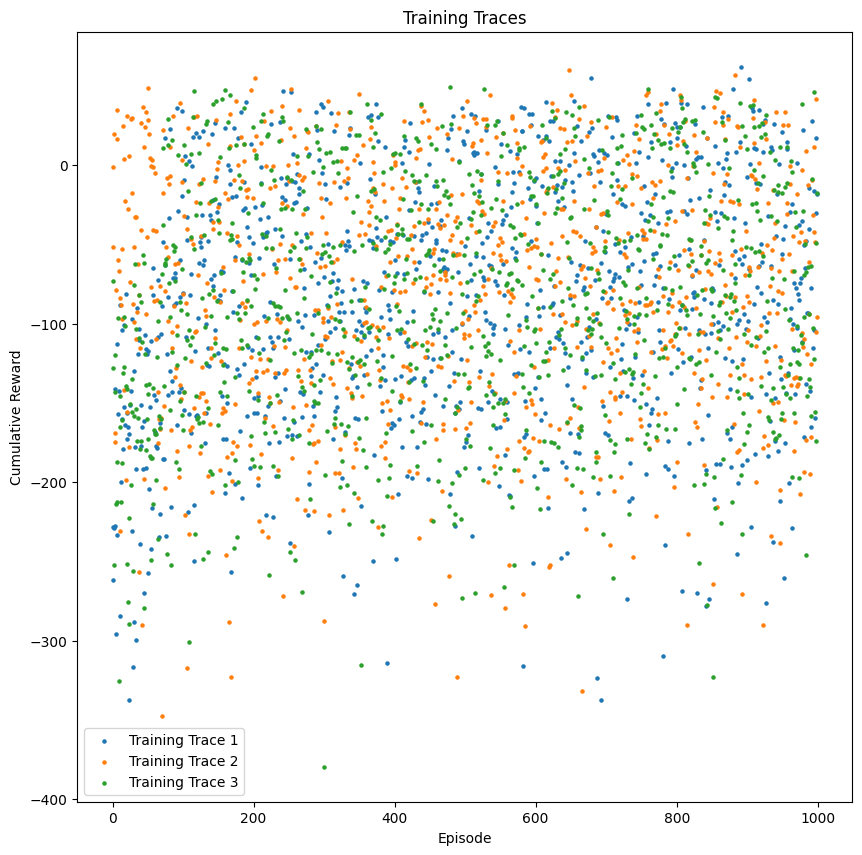

In [36]:
training_traces_scatterplot(train_traces, dots_size=5)

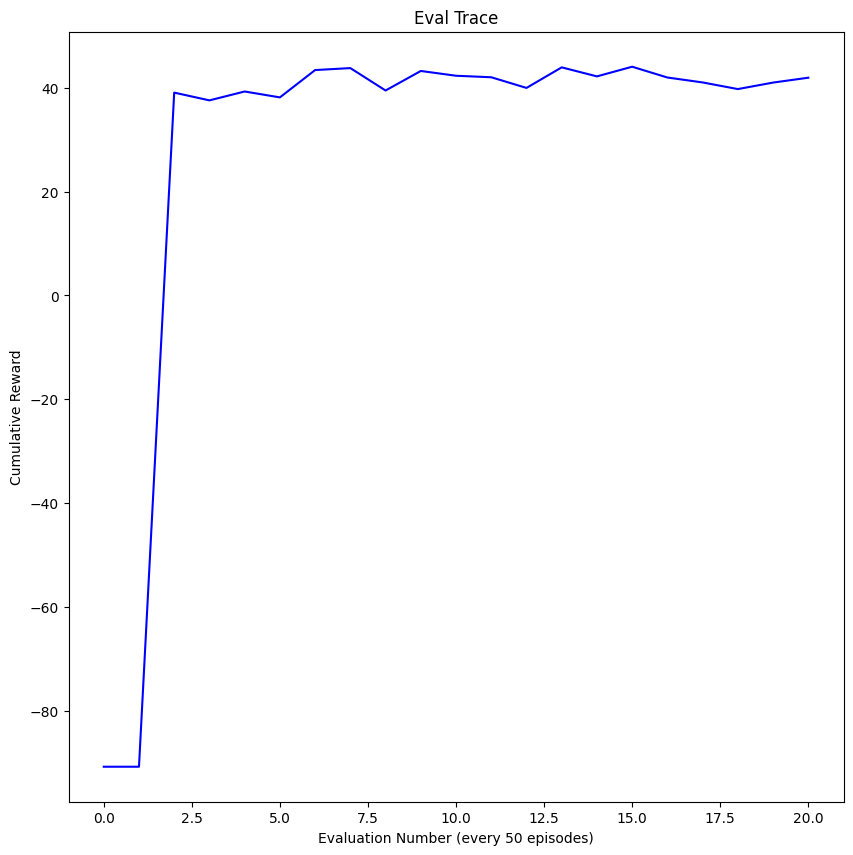

In [37]:
avg_eval_trace_lineplot(eval_traces)

**Is the model learning ?**  
Yes, the agent learns very quickly and converges to an average reward of about 40. The eval trace is very stable overall after the convergence, but the training trace wiggles a lot.

In [47]:
best_dqn_base_agent, best_dqn_base_idx = get_best_model(dqn_base_agents, eval_traces)
print("The best DQN base agent-{}".format(best_dqn_base_idx))

The best DQN base agent-1


In [48]:
logs = best_dqn_base_agent.eval_model(n_episodes=3).logs
log = logs[0]

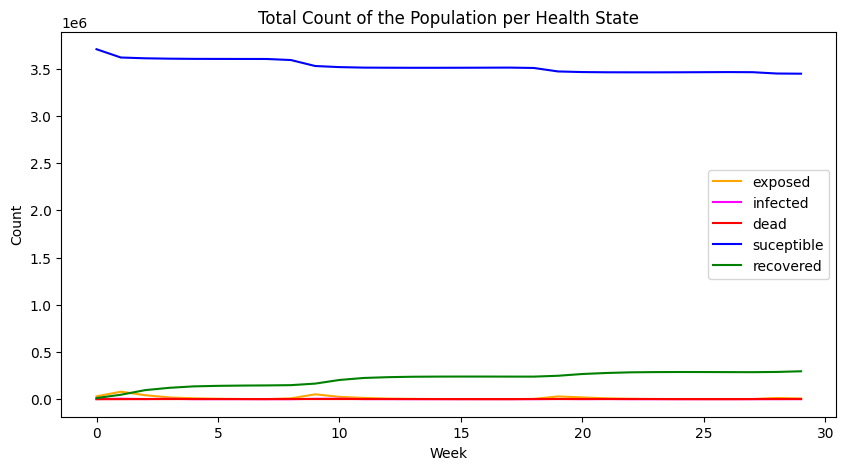

In [49]:
episode_totals_plot(log)

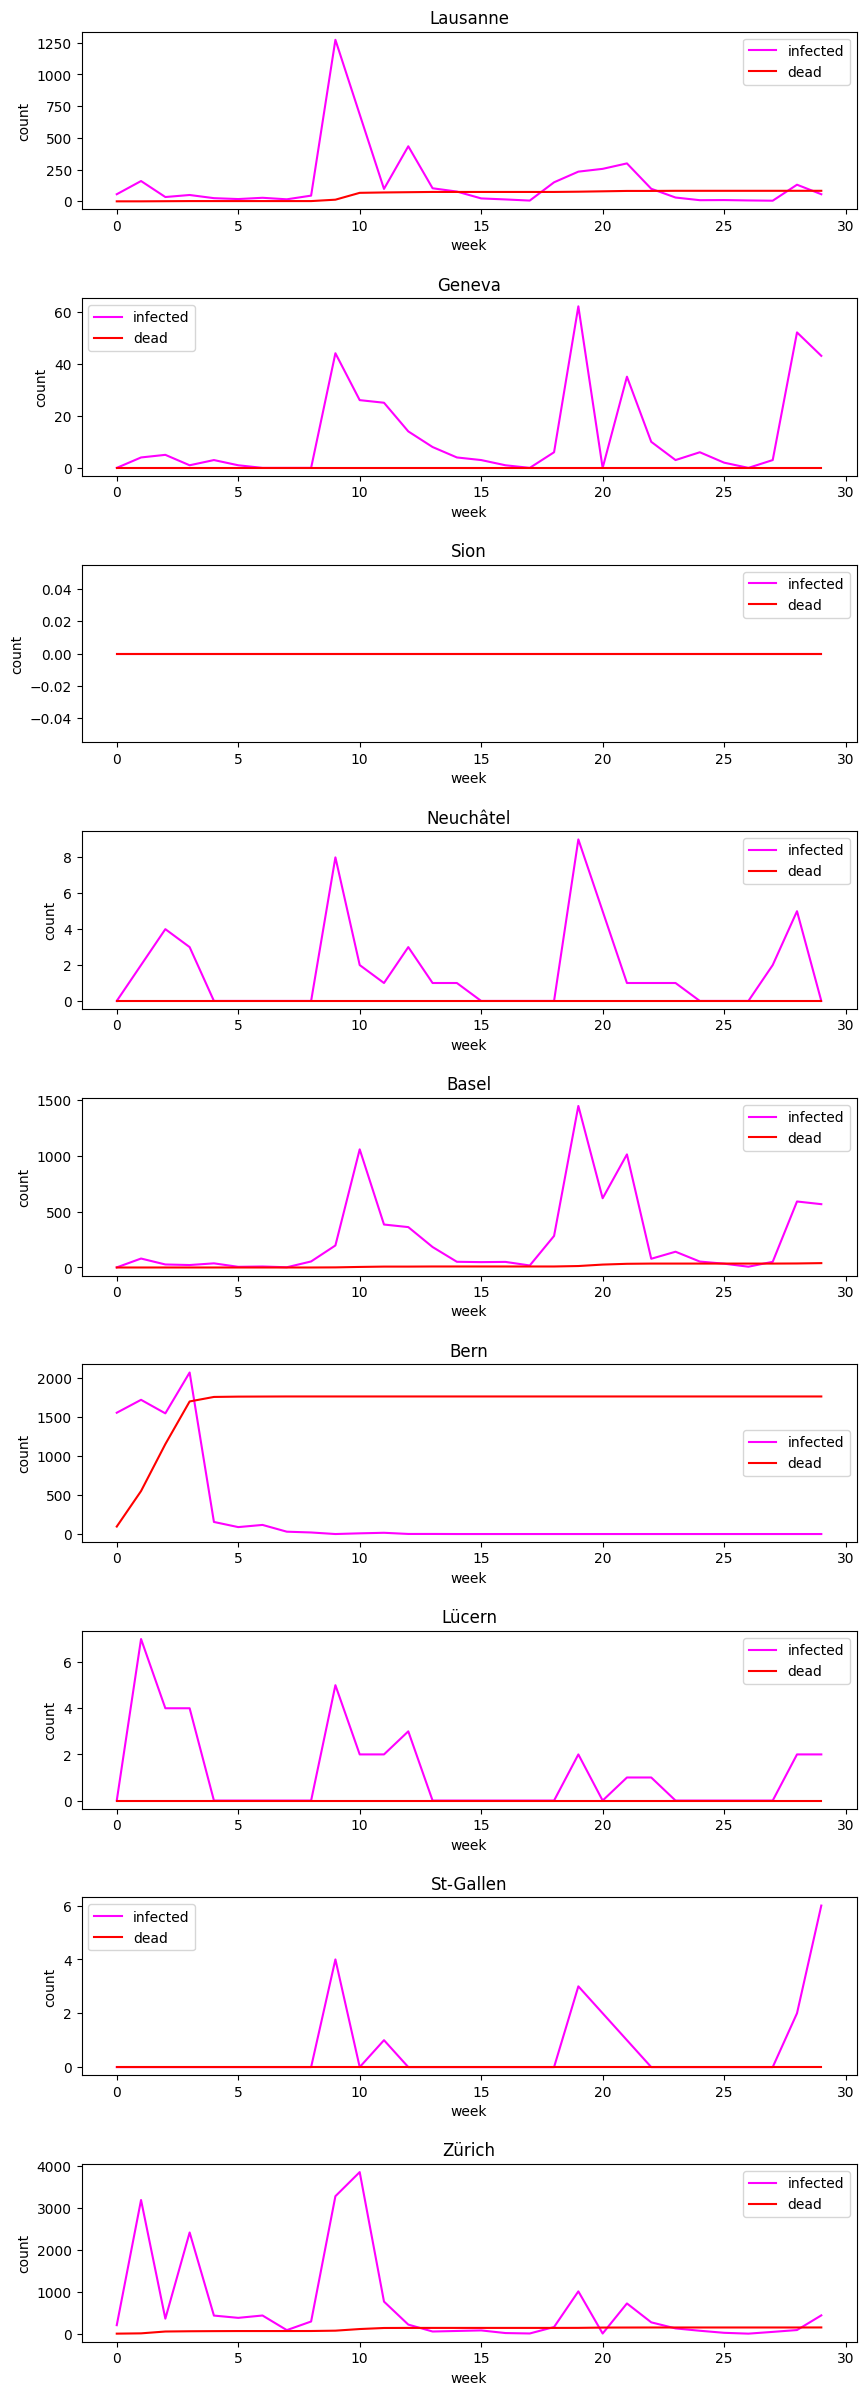

In [50]:
episode_city_totals_plot(log, health_states=["infected", "dead"], cities=dyn.cities)

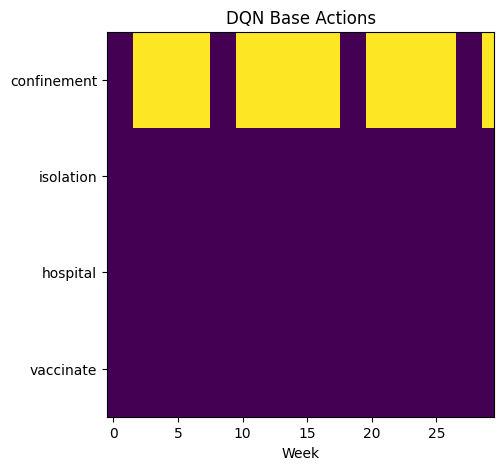

In [51]:
episode_actions_plot(log, actions=ACTIONS, title="DQN Base Actions")

**Does your agent learn a meaningful policy?**  
Yes the policy learnt by the agent is very interpretable: it follows the spike of the pandemics. By looking closely at the plot for Zürich in particular, we can see that the confinement happens at the beginning of the pandemic when the number of infected rises, but then the agent stops the confinement when the number of infected gets close or equal to 0 around week 7-8. After that, the number of infection starts to rise again around week 10, and the agent confines again in reaction.

## 3.b)

In [45]:
savepaths = ["./train/DQNWithExplorationDecay-{}.pt".format(model_number) for model_number in range(3)]
dqn_decay_agents_results = []

for seed_i, savepath in enumerate(savepaths):
    agent = DQNAgentWithExplorationDecay(env3)
    train_result = train(agent, savepath, n_episodes=1000)
    dqn_decay_agents_results.append((agent, train_result))

  0%|          | 0/1000 [00:00<?, ?it/s]

mean reward:  -147.55367529513313
AGENT SAVED


  5%|▌         | 50/1000 [00:32<07:30,  2.11it/s] 

mean reward:  -147.55367529513313
AGENT SAVED


 10%|█         | 100/1000 [01:17<12:45,  1.18it/s]

mean reward:  -147.55367529513313
AGENT SAVED


 15%|█▌        | 150/1000 [02:12<12:15,  1.16it/s]  

mean reward:  -147.55367529513313
AGENT SAVED


 20%|██        | 200/1000 [03:06<11:41,  1.14it/s]

mean reward:  -98.9500544071896
AGENT SAVED


 25%|██▌       | 250/1000 [04:00<10:25,  1.20it/s]

mean reward:  15.286611523851752
AGENT SAVED


 30%|███       | 300/1000 [04:51<09:46,  1.19it/s]

mean reward:  22.937940513342618
AGENT SAVED


 35%|███▌      | 350/1000 [05:44<09:13,  1.17it/s]

mean reward:  22.937940513342618
AGENT SAVED


 40%|████      | 400/1000 [06:35<08:30,  1.18it/s]

mean reward:  22.937940513342618
AGENT SAVED


 45%|████▌     | 450/1000 [07:28<07:49,  1.17it/s]

mean reward:  22.937940513342618
AGENT SAVED


 50%|█████     | 500/1000 [08:21<07:09,  1.16it/s]

mean reward:  26.666853096336126
AGENT SAVED


 55%|█████▌    | 550/1000 [09:14<06:29,  1.16it/s]

mean reward:  28.265604358166456
AGENT SAVED


 60%|██████    | 600/1000 [10:09<05:48,  1.15it/s]

mean reward:  31.296006214618682
AGENT SAVED


 65%|██████▌   | 650/1000 [11:02<05:06,  1.14it/s]

mean reward:  30.922923699766397


 70%|███████   | 700/1000 [11:55<04:38,  1.08it/s]

mean reward:  33.56093497425318
AGENT SAVED


 75%|███████▌  | 750/1000 [12:50<03:37,  1.15it/s]

mean reward:  32.112831107899545


 80%|████████  | 800/1000 [13:43<02:56,  1.13it/s]

mean reward:  37.373518196493386
AGENT SAVED


 85%|████████▌ | 850/1000 [14:38<02:11,  1.14it/s]

mean reward:  39.92632718086243
AGENT SAVED


 90%|█████████ | 900/1000 [15:31<01:29,  1.12it/s]

mean reward:  40.43332462757826
AGENT SAVED


 95%|█████████▌| 950/1000 [16:25<00:44,  1.13it/s]

mean reward:  34.33458098508417


100%|██████████| 1000/1000 [17:20<00:00,  1.04s/it]


mean reward:  32.884287072718145


  0%|          | 0/1000 [00:00<?, ?it/s]

mean reward:  22.937940513342618
AGENT SAVED


  5%|▌         | 50/1000 [00:31<07:14,  2.19it/s] 

mean reward:  22.937940513342618
AGENT SAVED


 10%|█         | 100/1000 [01:15<12:09,  1.23it/s]

mean reward:  22.937940513342618
AGENT SAVED


 15%|█▌        | 150/1000 [02:05<11:37,  1.22it/s]

mean reward:  -147.55367529513313


 20%|██        | 200/1000 [02:57<11:21,  1.17it/s]

mean reward:  -147.55367529513313


 25%|██▌       | 250/1000 [03:49<10:29,  1.19it/s]

mean reward:  -147.55367529513313


 30%|███       | 300/1000 [04:42<09:59,  1.17it/s]

mean reward:  -147.55367529513313


 35%|███▌      | 350/1000 [05:34<09:21,  1.16it/s]

mean reward:  -53.66260186764411


 40%|████      | 400/1000 [06:27<08:55,  1.12it/s]

mean reward:  22.937940513342618
AGENT SAVED


 45%|████▌     | 450/1000 [07:22<07:56,  1.15it/s]

mean reward:  22.937940513342618
AGENT SAVED


 50%|█████     | 500/1000 [08:15<07:19,  1.14it/s]

mean reward:  22.937940513342618
AGENT SAVED


 55%|█████▌    | 550/1000 [09:10<06:37,  1.13it/s]

mean reward:  22.937940513342618
AGENT SAVED


 60%|██████    | 600/1000 [10:04<05:55,  1.13it/s]

mean reward:  22.937940513342618
AGENT SAVED


 65%|██████▌   | 650/1000 [10:57<05:13,  1.12it/s]

mean reward:  24.016389756649733
AGENT SAVED


 70%|███████   | 700/1000 [11:53<04:26,  1.13it/s]

mean reward:  23.933118898421526


 75%|███████▌  | 750/1000 [12:47<03:46,  1.10it/s]

mean reward:  28.393890868872404
AGENT SAVED


 80%|████████  | 800/1000 [13:41<02:58,  1.12it/s]

mean reward:  30.77854487672448
AGENT SAVED


 85%|████████▌ | 850/1000 [14:37<02:14,  1.11it/s]

mean reward:  41.16864684298635
AGENT SAVED


 90%|█████████ | 900/1000 [15:31<01:30,  1.11it/s]

mean reward:  42.55829605534673
AGENT SAVED


 95%|█████████▌| 950/1000 [16:28<00:45,  1.10it/s]

mean reward:  42.55725599303842


100%|██████████| 1000/1000 [17:22<00:00,  1.04s/it]


mean reward:  43.28171476125717
AGENT SAVED


  0%|          | 0/1000 [00:00<?, ?it/s]

mean reward:  22.937940513342618
AGENT SAVED


  5%|▌         | 50/1000 [00:31<07:11,  2.20it/s] 

mean reward:  22.937940513342618
AGENT SAVED


 10%|█         | 100/1000 [01:14<11:58,  1.25it/s]

mean reward:  22.937940513342618
AGENT SAVED


 15%|█▌        | 150/1000 [02:05<11:35,  1.22it/s]

mean reward:  -147.55367529513313


 20%|██        | 200/1000 [02:56<10:59,  1.21it/s]

mean reward:  -147.55367529513313


 25%|██▌       | 250/1000 [03:46<10:26,  1.20it/s]

mean reward:  -147.55367529513313


 30%|███       | 300/1000 [04:40<09:55,  1.18it/s]

mean reward:  -147.55367529513313


 35%|███▌      | 350/1000 [05:32<09:21,  1.16it/s]

mean reward:  22.937940513342618
AGENT SAVED


 40%|████      | 400/1000 [06:26<08:31,  1.17it/s]

mean reward:  22.937940513342618
AGENT SAVED


 45%|████▌     | 450/1000 [07:22<08:05,  1.13it/s]

mean reward:  22.937940513342618
AGENT SAVED


 50%|█████     | 500/1000 [08:15<07:27,  1.12it/s]

mean reward:  22.937940513342618
AGENT SAVED


 55%|█████▌    | 550/1000 [09:09<06:41,  1.12it/s]

mean reward:  22.937940513342618
AGENT SAVED


 60%|██████    | 600/1000 [10:05<05:56,  1.12it/s]

mean reward:  22.937940513342618
AGENT SAVED


 65%|██████▌   | 650/1000 [10:59<05:16,  1.11it/s]

mean reward:  22.937940513342618
AGENT SAVED


 70%|███████   | 700/1000 [11:52<04:26,  1.13it/s]

mean reward:  24.427140357345344
AGENT SAVED


 75%|███████▌  | 750/1000 [12:49<03:42,  1.12it/s]

mean reward:  23.979680316895248


 80%|████████  | 800/1000 [13:43<03:01,  1.10it/s]

mean reward:  27.906615366786717
AGENT SAVED


 85%|████████▌ | 850/1000 [14:38<02:15,  1.11it/s]

mean reward:  37.90727351531386
AGENT SAVED


 90%|█████████ | 900/1000 [15:34<01:29,  1.11it/s]

mean reward:  40.31179464384913
AGENT SAVED


 95%|█████████▌| 950/1000 [16:29<00:45,  1.10it/s]

mean reward:  39.70690236464143


100%|██████████| 1000/1000 [17:24<00:00,  1.04s/it]


mean reward:  35.9263909637928


In [55]:
dqn_decay_agents = list(map(lambda x: x[0], dqn_decay_agents_results))
train_traces, eval_traces = zip(*list(map(lambda item: (item[1].train_trace, item[1].eval_trace), dqn_decay_agents_results)))

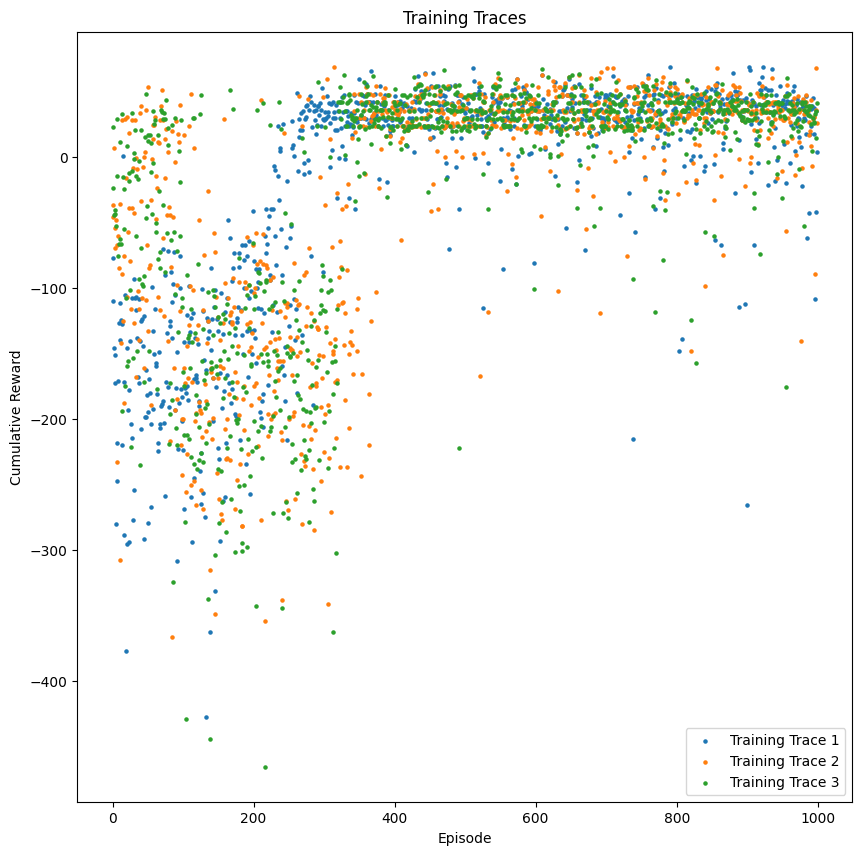

In [56]:
training_traces_scatterplot(train_traces, dots_size=5)

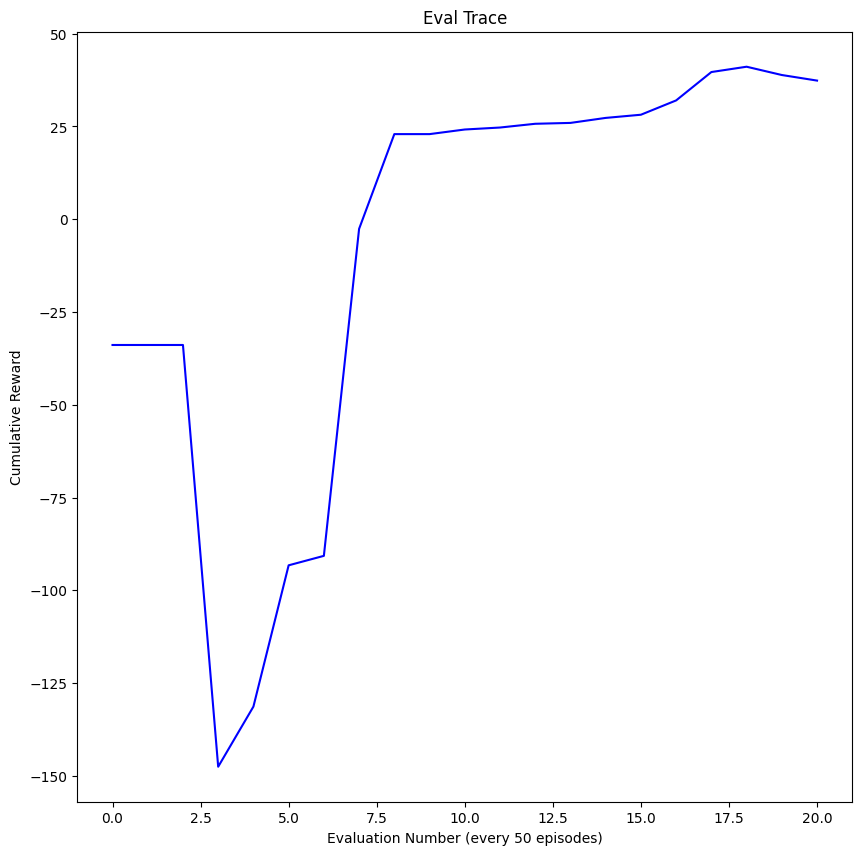

In [57]:
avg_eval_trace_lineplot(eval_traces)

In [58]:
best_dqn_decay_agent, best_dqn_decay_idx = get_best_model(dqn_decay_agents, eval_traces)
print("The best DQN decay agent -{}".format(best_dqn_decay_idx))

The best DQN decay agent -1


In [59]:
logs = best_dqn_decay_agent.eval_model(n_episodes=3).logs
log = logs[0]

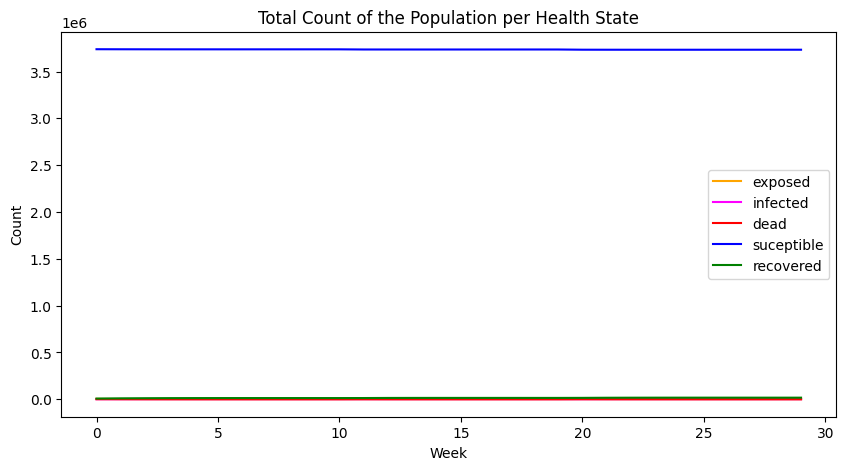

In [60]:
episode_totals_plot(log)

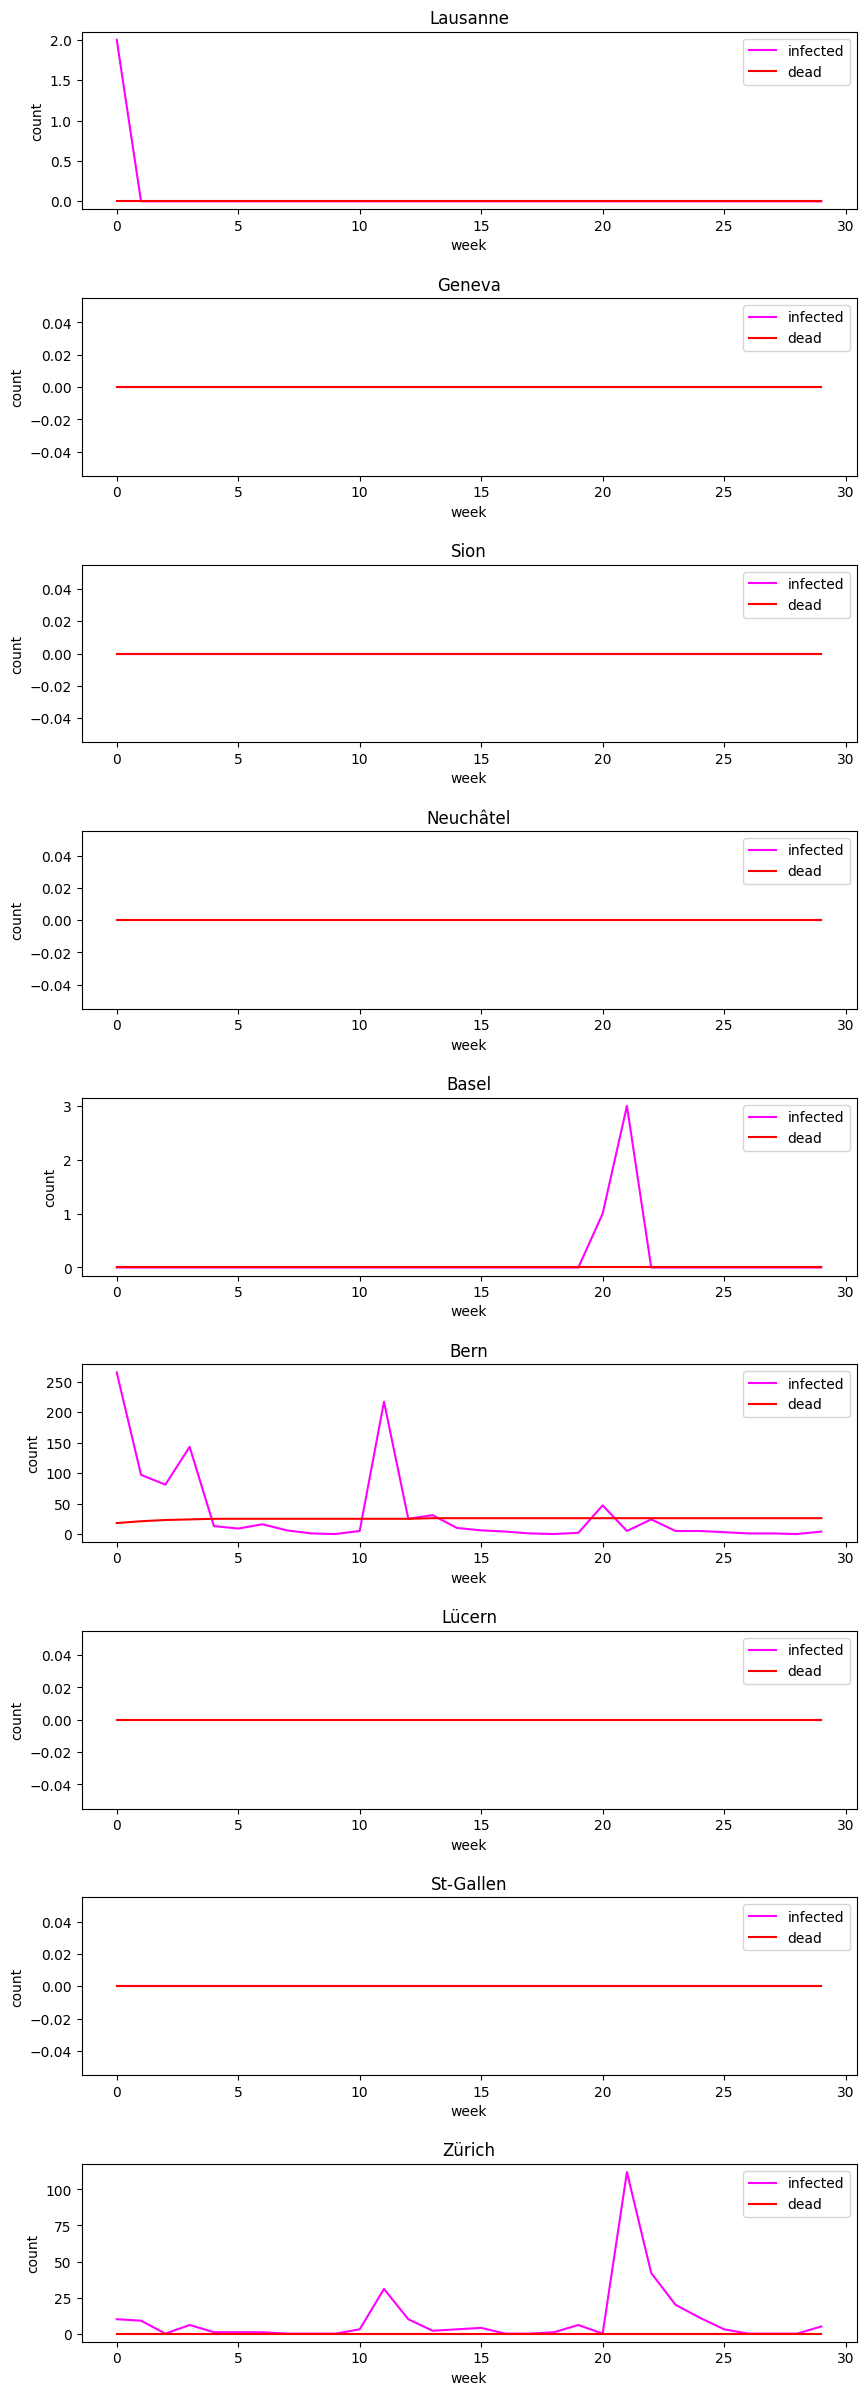

In [61]:
episode_city_totals_plot(log, health_states=["infected", "dead"], cities=dyn.cities)

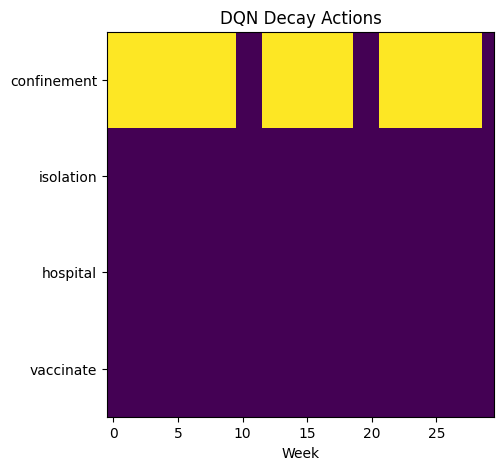

In [62]:
episode_actions_plot(log, actions=ACTIONS, title="DQN Decay Actions")

**Which policy gets the best results and why?**  
Both eval traces yield similar result in terms of average reward in eval, except an initial drop of average reward in eval for the decreasing exploration policy, which is probably due to high exploration at the beginning of training. However, we see with the train trace that the decreasing exploration gives a more stable training towards the end of the training compared to the training trace of 3.a).  
The decreasing exploration policy is more desirable, because it explores more at the beginning of the training, so that the agent learns the q_values for all the actions. Then, it exploits good actions at the end of the training to achieve a good average reward.

## 3.c)

In [6]:
# reload the best dqn agent 
best_dqn_agent_idx = 1
best_dqn_agent_path ="./train/DQN-base-{}.pt".format(best_dqn_agent_idx)
best_dqn_agent = DQNAgentWithExplorationDecay(env3)
best_dqn_agent.load_model(best_dqn_agent_path)
eval_result = best_dqn_agent.eval_model(n_episodes=1, compute_qvals=False)

In [7]:
best_dqn_eval_result = best_dqn_agent.eval_model(n_episodes=50)

Average death number: 1942.84
Average number of confined days: 163.1
Average number of isolation days: 0.0
Average number of hospital days: 0.0
Average number of vaccination days: 0.0
Average cumulative reward: 49.82268895491958


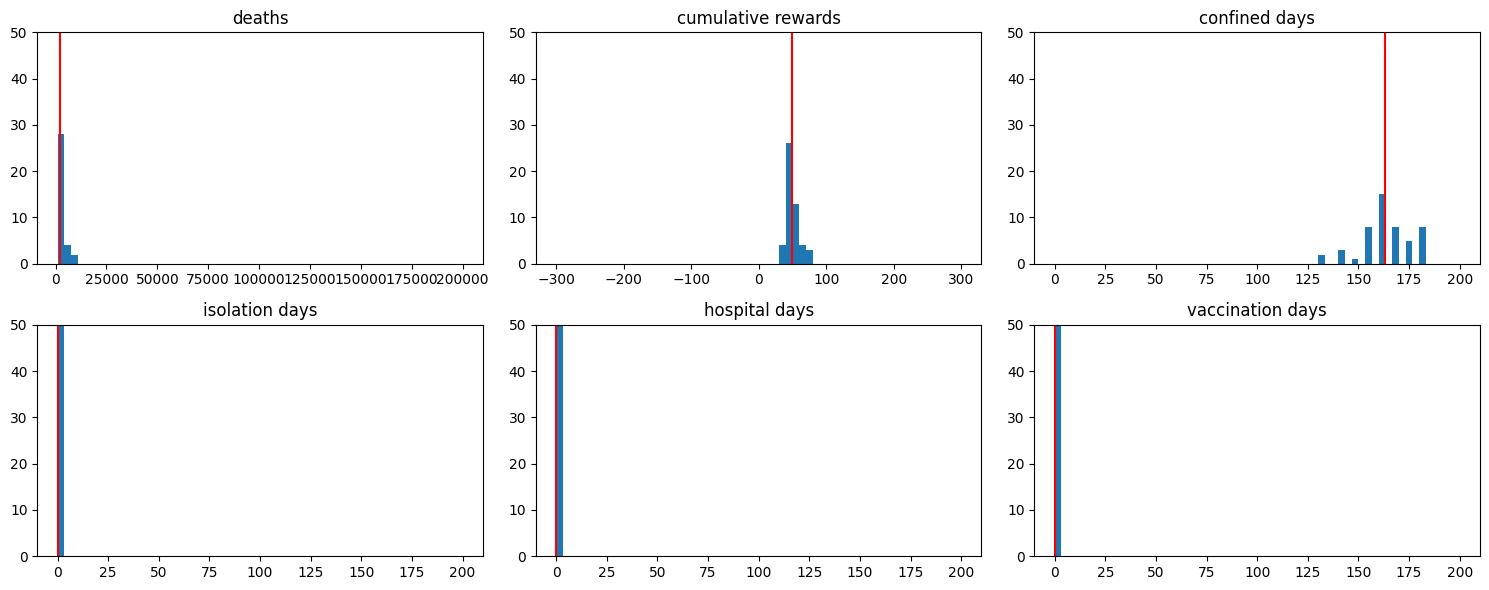

In [8]:
fig, ax = plt.subplots(2, 3,figsize=(15, 6))

hist_avg(ax[0][0], best_dqn_eval_result.deaths,'deaths')
hist_avg(ax[0][1], best_dqn_eval_result.cum_rewards,'cumulative rewards')
hist_avg(ax[0][2], best_dqn_eval_result.confinement_days,'confined days')
hist_avg(ax[1][0], best_dqn_eval_result.isolation_days,'isolation days')
hist_avg(ax[1][1], best_dqn_eval_result.hospital_days,'hospital days')
hist_avg(ax[1][2], best_dqn_eval_result.vaccinate_days,'vaccination days')
fig.tight_layout()

print(f'Average death number: {np.mean(best_dqn_eval_result.deaths)}')
print(f'Average number of confined days: {np.mean(best_dqn_eval_result.confinement_days)}')
print(f'Average number of isolation days: {np.mean(best_dqn_eval_result.isolation_days)}')
print(f'Average number of hospital days: {np.mean(best_dqn_eval_result.hospital_days)}')
print(f'Average number of vaccination days: {np.mean(best_dqn_eval_result.vaccinate_days)}')
print(f'Average cumulative reward: {np.mean(best_dqn_eval_result.cum_rewards)}')

**Did the reinforcement learning policy outperform Pr. Russo’s, if so in what sense?**  
First, we see that the average reward for the RL policy (49.82) is much higher than for Pr. Russo's policy (-62.12)
If we compare the deaths, the average number of deaths for the RL policy is 1942.84, while it's 55443.66 for the Russo policy. The average number of confinement days is 163.1 for the RL policy, and 103.32 for Pr. Russo's policy.  
On average, the RL policy confines more than Pr. Russo's policy, but the average number of deaths is much lower.

# PART 4

## Question 4.1

### Question 4.1.a

With the previous observation-action space, our neural networks needs 16 output neurons, each of which is the Q-value of a possible action given the state. With the suggested observation-action space, our neural networks will have 5 output neurons only, one for each toggle action and one for the do-nothing action, at the cost of 4 more input neurons whose values are 0 or 1 corresponding to the last action taken.

With a thiner output layer, the model could learn faster since it needs to learn less Q-values because the action space is reduced and so each action may occur more often in training.

### Question 4.1.b

In [17]:
n_toggle_actions = len(TOGGLE_ACTIONS)

multiaction_action_space = spaces.Discrete(n_toggle_actions)
multiaction_observation_space = spaces.Dict({
    "observation": spaces.Box(low=0, high=1, shape=(2, dyn.n_cities, dyn.env_step_length), dtype=np.float16),
    "prev_action": spaces.Discrete(n_toggle_actions - 1)
    })

env4 = Env(dyn,
           observation_space=multiaction_observation_space,
           action_space=multiaction_action_space,
           observation_preprocessor=toggleaction_dqn_observation_preprocessor,
           action_preprocessor=toggleaction_dqn_action_preprocessor)

In [18]:
savepaths = ["./train/DQN-toggleaction-{}.pt".format(model_number) for model_number in range(3)]
dqn_toggleaction_agents_results = []

for seed_i, savepath in enumerate(savepaths):
    agent = DQNAgentWithExplorationDecay(env4, lr=1e-5)
    train_result = train(agent, savepath, n_episodes=1000)
    dqn_toggleaction_agents_results.append((agent, train_result))

  0%|          | 0/1000 [00:00<?, ?it/s]

mean reward:  -67.33769845072747
AGENT SAVED


  5%|▌         | 50/1000 [00:32<07:33,  2.10it/s] 

mean reward:  -67.33769845072747
AGENT SAVED


 10%|█         | 100/1000 [01:17<13:01,  1.15it/s]

mean reward:  -110.3426262171939


 15%|█▌        | 150/1000 [02:05<11:01,  1.28it/s]

mean reward:  -141.97510412679986


 20%|██        | 200/1000 [02:55<11:12,  1.19it/s]

mean reward:  -150.86577832242475


 25%|██▌       | 250/1000 [03:45<10:22,  1.20it/s]

mean reward:  -140.5984088790603


 30%|███       | 300/1000 [04:35<09:29,  1.23it/s]

mean reward:  -139.35530068073422


 35%|███▌      | 350/1000 [05:28<09:20,  1.16it/s]

mean reward:  -148.39442627104


 40%|████      | 400/1000 [06:18<08:12,  1.22it/s]

mean reward:  -159.1144260685891


 45%|████▌     | 450/1000 [07:11<08:13,  1.11it/s]

mean reward:  -149.09168876893818


 50%|█████     | 500/1000 [08:05<08:02,  1.04it/s]

mean reward:  -148.59801356457174


 55%|█████▌    | 550/1000 [09:00<07:27,  1.00it/s]

mean reward:  -134.73953130096197


 60%|██████    | 600/1000 [09:54<05:41,  1.17it/s]

mean reward:  -134.21810048148035


 65%|██████▌   | 650/1000 [10:49<05:21,  1.09it/s]

mean reward:  -134.8992628082633


 70%|███████   | 700/1000 [11:45<04:32,  1.10it/s]

mean reward:  -129.1231062039733


 75%|███████▌  | 750/1000 [12:38<03:44,  1.11it/s]

mean reward:  -116.6930081587052


 80%|████████  | 800/1000 [13:32<02:54,  1.15it/s]

mean reward:  -120.05992499997373


 85%|████████▌ | 850/1000 [14:27<02:14,  1.12it/s]

mean reward:  -120.91563103394583


 90%|█████████ | 900/1000 [15:24<01:33,  1.07it/s]

mean reward:  -121.32732975666877


 95%|█████████▌| 950/1000 [16:20<00:46,  1.07it/s]

mean reward:  -116.40874710502104


100%|██████████| 1000/1000 [17:16<00:00,  1.04s/it]


mean reward:  -64.13883965747664
AGENT SAVED


  0%|          | 0/1000 [00:00<?, ?it/s]

mean reward:  -233.34911914360708
AGENT SAVED


  5%|▌         | 50/1000 [00:32<07:18,  2.17it/s] 

mean reward:  -233.34911914360708
AGENT SAVED


 10%|█         | 100/1000 [01:17<11:50,  1.27it/s]

mean reward:  -90.13763729147612
AGENT SAVED


 15%|█▌        | 150/1000 [02:30<12:53,  1.10it/s]

mean reward:  -76.13861555457115
AGENT SAVED


 20%|██        | 200/1000 [03:25<13:14,  1.01it/s]

mean reward:  -63.8256632886827
AGENT SAVED


 25%|██▌       | 250/1000 [04:23<11:44,  1.06it/s]

mean reward:  -31.455803897231817
AGENT SAVED


 30%|███       | 300/1000 [05:20<10:36,  1.10it/s]

mean reward:  -24.09020018093288
AGENT SAVED


 35%|███▌      | 350/1000 [06:18<12:16,  1.13s/it]

mean reward:  -36.98852094821632


 40%|████      | 400/1000 [07:19<10:08,  1.01s/it]

mean reward:  -55.21455880217254


 45%|████▌     | 450/1000 [08:18<08:51,  1.03it/s]

mean reward:  -61.086136266961695


 50%|█████     | 500/1000 [09:14<07:36,  1.09it/s]

mean reward:  -66.55949181132019


 55%|█████▌    | 550/1000 [10:12<07:41,  1.03s/it]

mean reward:  -71.37960615754128


 60%|██████    | 600/1000 [11:10<06:09,  1.08it/s]

mean reward:  -69.28957361280918


 65%|██████▌   | 650/1000 [12:06<05:24,  1.08it/s]

mean reward:  -79.54672865215689


 70%|███████   | 700/1000 [12:59<04:09,  1.20it/s]

mean reward:  -72.05513952765614


 75%|███████▌  | 750/1000 [13:54<03:53,  1.07it/s]

mean reward:  -58.25410597380251


 80%|████████  | 800/1000 [14:49<02:38,  1.26it/s]

mean reward:  -79.71955718919635


 85%|████████▌ | 850/1000 [15:40<02:02,  1.23it/s]

mean reward:  -54.453640688210726


 90%|█████████ | 900/1000 [16:31<01:22,  1.21it/s]

mean reward:  -40.667481114342806


 95%|█████████▌| 950/1000 [17:21<00:40,  1.23it/s]

mean reward:  -84.07544334629783


100%|██████████| 1000/1000 [18:12<00:00,  1.09s/it]


mean reward:  -87.95098429652862


  0%|          | 0/1000 [00:00<?, ?it/s]

mean reward:  -233.34911914360708
AGENT SAVED


  5%|▌         | 50/1000 [00:31<07:07,  2.22it/s] 

mean reward:  -233.34911914360708
AGENT SAVED


 10%|█         | 100/1000 [01:12<11:07,  1.35it/s]

mean reward:  -87.01589914411306
AGENT SAVED


 15%|█▌        | 150/1000 [02:03<12:56,  1.09it/s]

mean reward:  -76.8655259296298
AGENT SAVED


 20%|██        | 200/1000 [02:52<10:25,  1.28it/s]

mean reward:  -77.72179423086345


 25%|██▌       | 250/1000 [03:45<10:28,  1.19it/s]

mean reward:  -54.50160824337509
AGENT SAVED


 30%|███       | 300/1000 [04:44<10:37,  1.10it/s]

mean reward:  -58.55973226687638


 35%|███▌      | 350/1000 [05:36<09:43,  1.11it/s]

mean reward:  -44.851328418497
AGENT SAVED


 40%|████      | 400/1000 [06:25<07:55,  1.26it/s]

mean reward:  -94.28030184525997


 45%|████▌     | 450/1000 [07:16<07:26,  1.23it/s]

mean reward:  -68.20189108784544


 50%|█████     | 500/1000 [08:06<06:41,  1.24it/s]

mean reward:  -82.75935184748377


 55%|█████▌    | 550/1000 [08:57<06:21,  1.18it/s]

mean reward:  -74.25417439371813


 60%|██████    | 600/1000 [09:47<05:34,  1.20it/s]

mean reward:  -47.98202083461219


 65%|██████▌   | 650/1000 [10:40<04:57,  1.18it/s]

mean reward:  -62.56993104421999


 70%|███████   | 700/1000 [11:31<04:09,  1.20it/s]

mean reward:  -40.42030794651946
AGENT SAVED


 75%|███████▌  | 750/1000 [12:22<03:28,  1.20it/s]

mean reward:  -57.324645391548984


 80%|████████  | 800/1000 [13:14<02:47,  1.20it/s]

mean reward:  -59.678856292821


 85%|████████▌ | 850/1000 [14:06<02:04,  1.20it/s]

mean reward:  -77.28065965586575


 90%|█████████ | 900/1000 [14:58<01:53,  1.14s/it]

mean reward:  -79.09294688728406


 95%|█████████▌| 950/1000 [15:49<00:41,  1.21it/s]

mean reward:  -69.74407476028428


100%|██████████| 1000/1000 [16:42<00:00,  1.00s/it]


mean reward:  -68.66231658597243


In [19]:
dqn_multiaction_agents = list(map(lambda item: item[0], dqn_toggleaction_agents_results))
train_traces, eval_traces = zip(*list(map(lambda item: (item[1].train_trace, item[1].eval_trace), dqn_toggleaction_agents_results)))

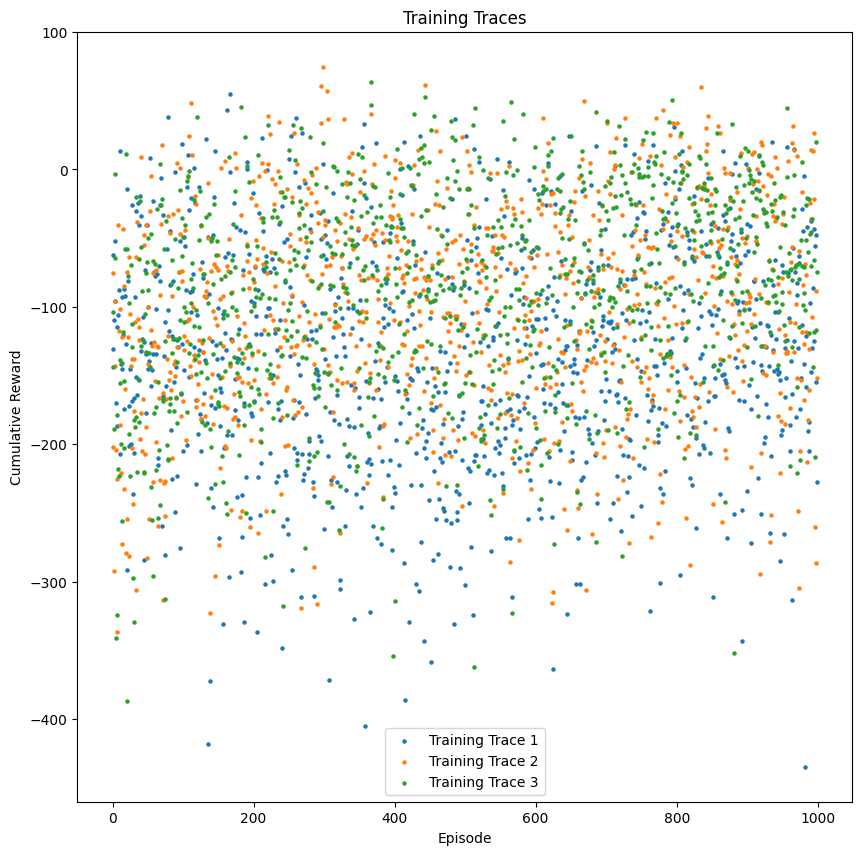

In [20]:
training_traces_scatterplot(train_traces, dots_size=5)

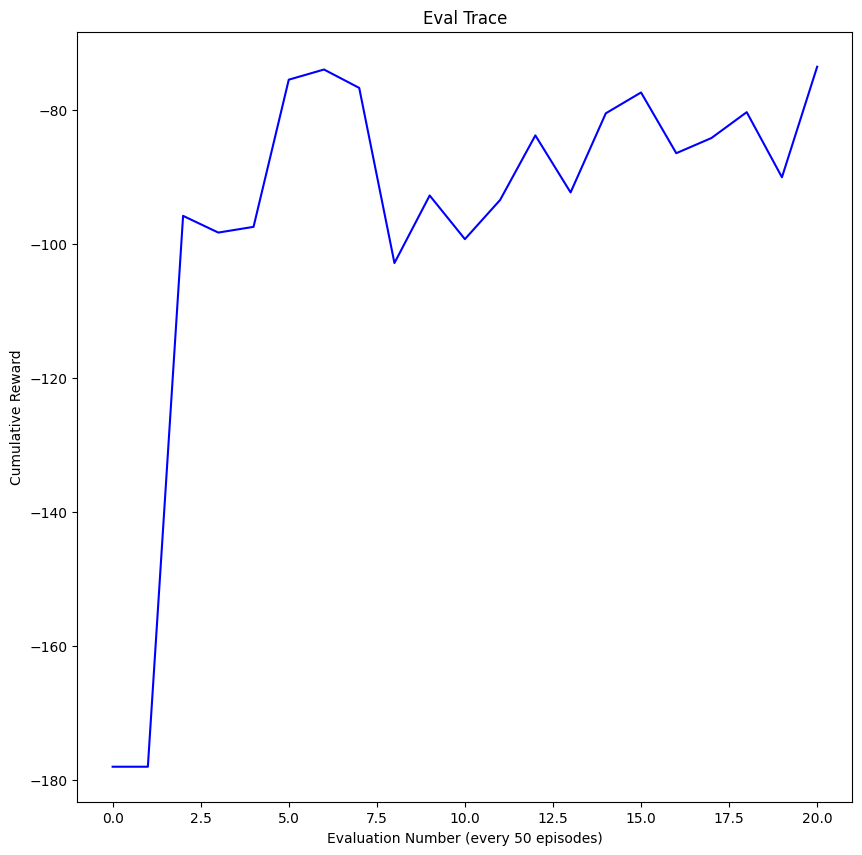

In [21]:
avg_eval_trace_lineplot(eval_traces)

**Is the model learning?**

Yes, the model is learning because the evaluation trace is ascending overall. Moreover, there seems to be a higher concentration of training traces in the upper half of the corresponding plot. However, there is no sign of convergence to a good policy because the best evaluation trace is around -80, compared to Russo policy which had around -62. Furthermore, even after exploration becomes very minimal in the latest episodes of training, the training trace shows that there is still a non-negligible portion of episodes in which the policy performs very badly and the trace is less than -200.

In [22]:
best_dqn_toggleaction_agent, best_dqn_toggleaction_idx = get_best_model(dqn_multiaction_agents, eval_traces)
print("The best DQN toggle action agent DQN-toggleaction-{}".format(best_dqn_toggleaction_idx))

The best DQN toggle action agent DQN-toggleaction-1


In [23]:
best_dqn_toggleaction_agent = DQNAgentWithExplorationDecay(env4, lr=1e-5)
best_dqn_toggleaction_agent.load_model(savepaths[best_dqn_toggleaction_idx])

In [24]:
logs = best_dqn_toggleaction_agent.eval_model(n_episodes=3).logs

In [25]:
# choose the log of the first episode
log = logs[2]

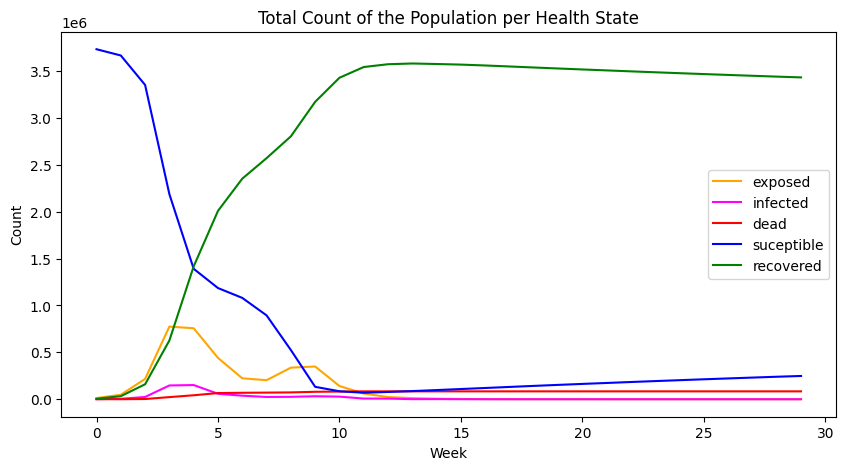

In [26]:
episode_totals_plot(log)

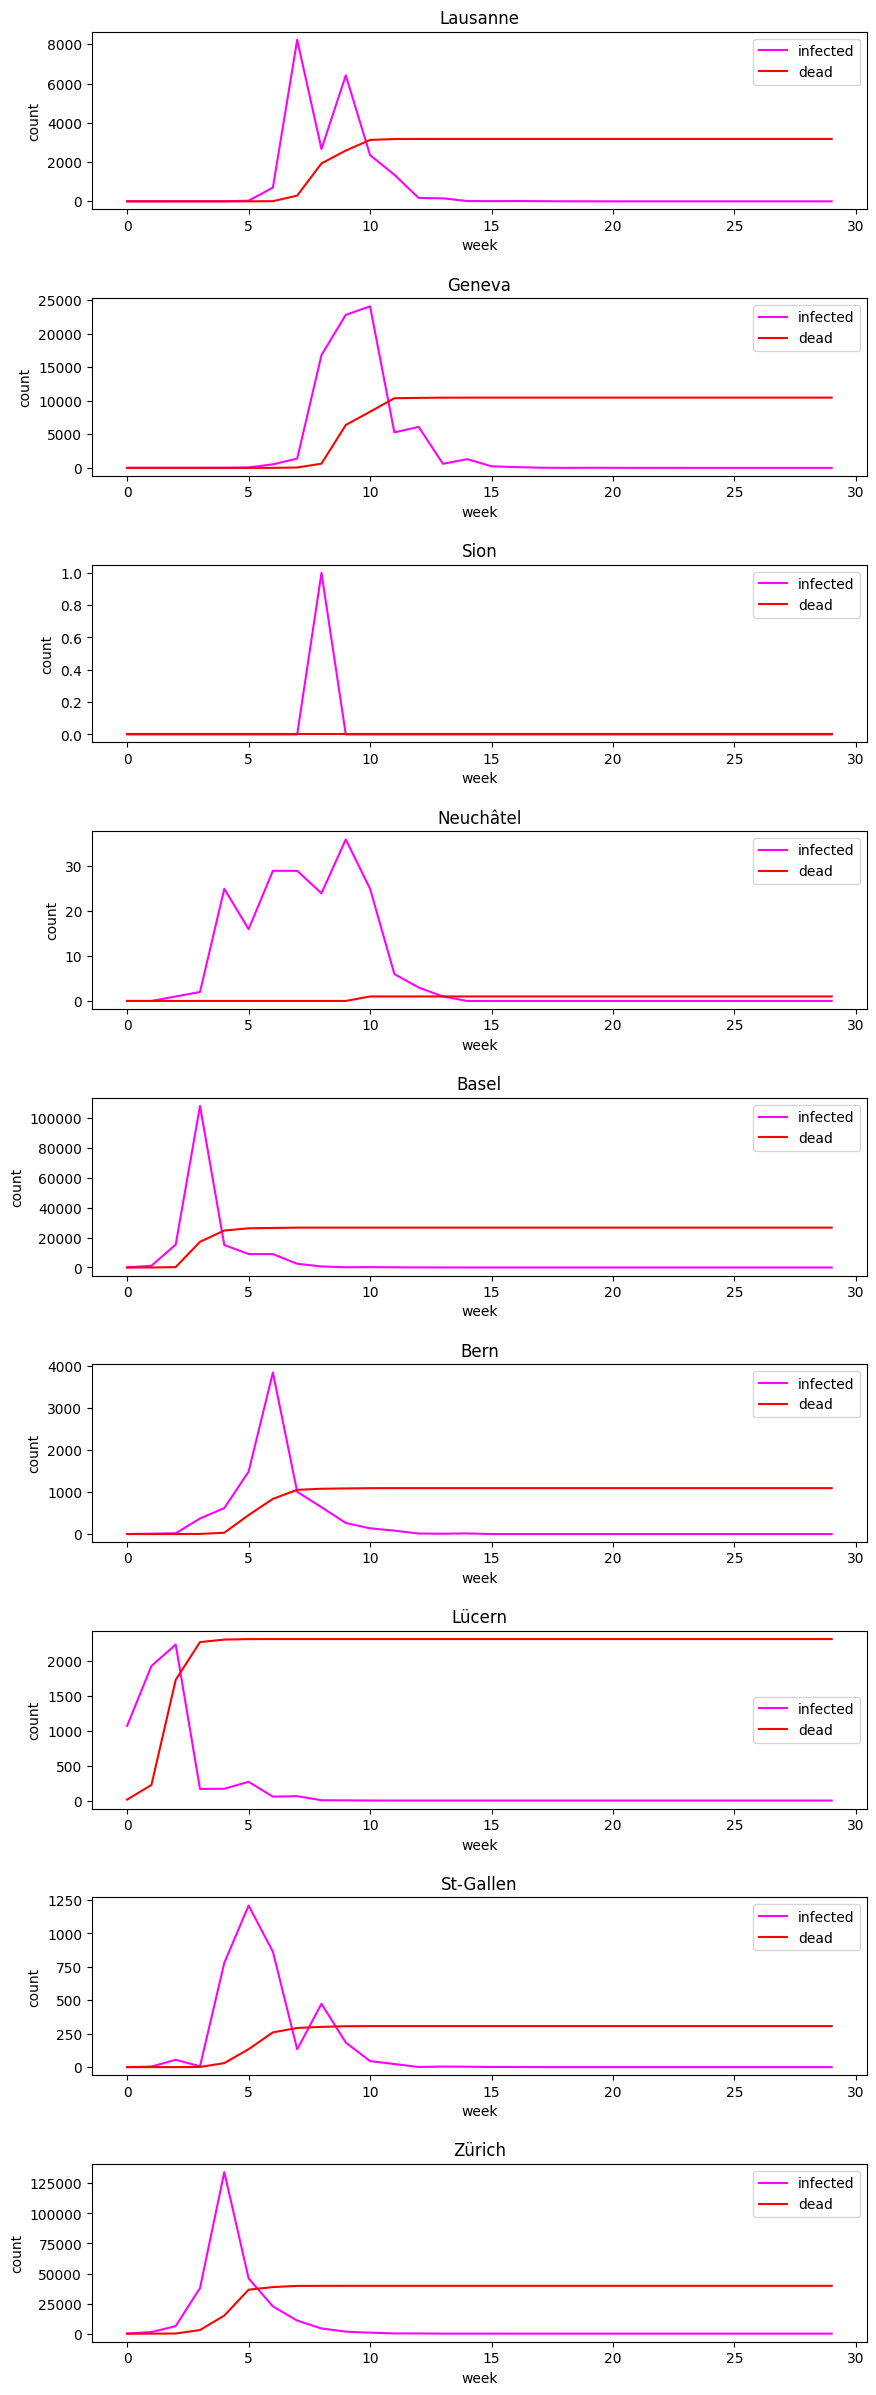

In [27]:
episode_city_totals_plot(log, health_states=["infected", "dead"], cities=dyn.cities)

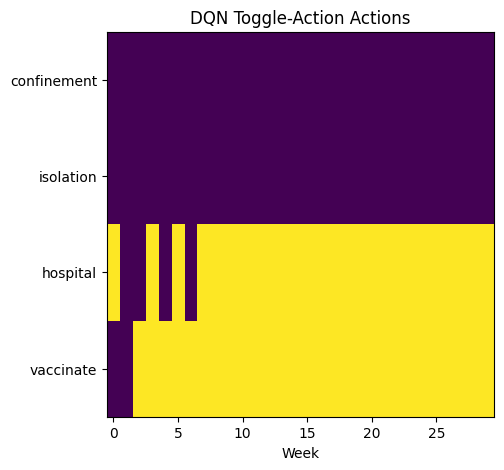

In [28]:
episode_actions_plot(log, actions=ACTIONS, title="DQN Toggle-Action Actions")

**Policy Interpretation**

When the epidemic starts in Lucern, it opts for hospital as a measure mitigating deaths without having to take more drastic and costly preventive measures. In the next step, it chooses to turn off hospital perhaps because keeping it activated is more costly than waiting to see what happens next. In the next steps, as the epidemic spreads widely as can be seen from the graphs of the cities, the agent opts for vaccination and alternates a few times between hospital on and off, then it keeps it activated. Perhaps the reasons are that vaccination can limit the number of infections even if it's costly, and the hospital mitigates the number of deaths. However, it does not make sense to take those actions by the end of the epidemic (week 15+ in most cities) because with a small number of infected people the agent is incuring cost without much attenuation.

Overall, due to the model's inflexibility (toggling only is allowed), the epidemic is given time to spread before the agent reacts to it since toggling is from one policy to another may require multiple steps and during that time the optimal policy may have shifted.

### Question 4.1.c

In [29]:
best_dqn_toggleaction_eval_result = best_dqn_toggleaction_agent.eval_model(n_episodes=50)

Average death number: 76631.88
Average number of confined days: 0.0
Average number of isolation days: 0.0
Average number of hospital days: 109.48
Average number of vaccination days: 128.66
Average cumulative reward: -44.35199137788266


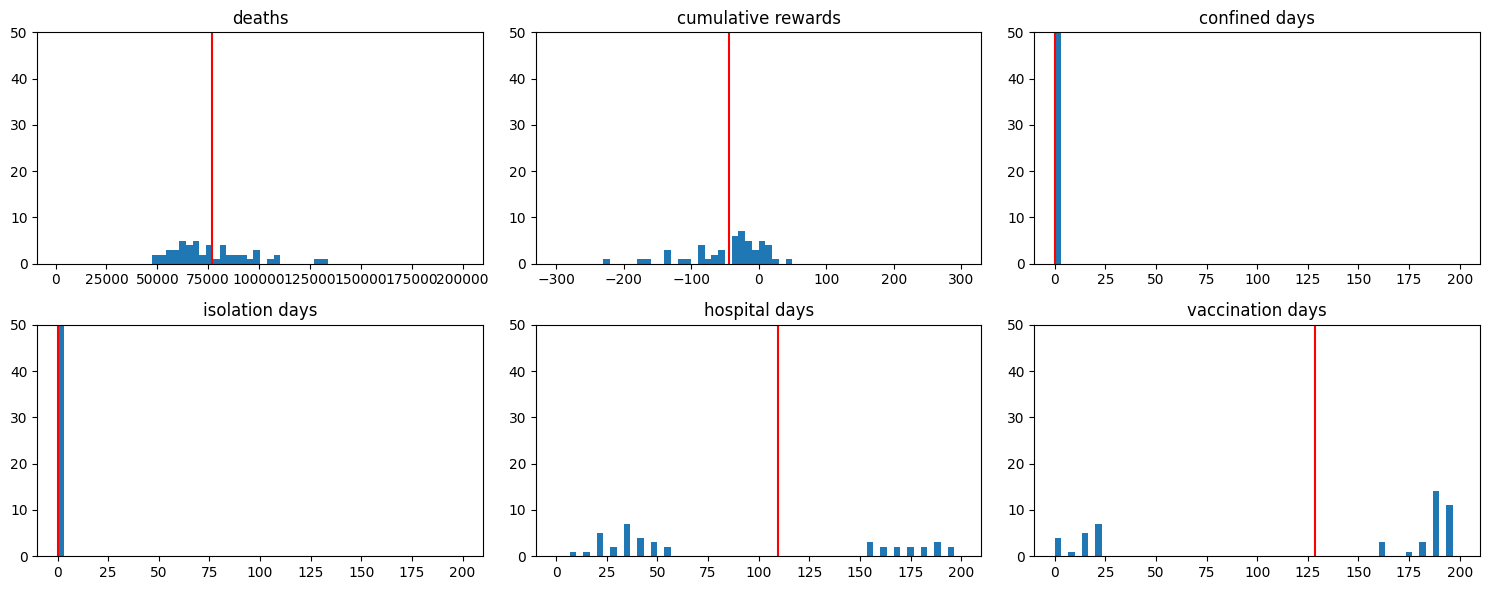

In [30]:
fig, ax = plt.subplots(2, 3,figsize=(15, 6))

hist_avg(ax[0][0], best_dqn_toggleaction_eval_result.deaths,'deaths')
hist_avg(ax[0][1], best_dqn_toggleaction_eval_result.cum_rewards,'cumulative rewards')
hist_avg(ax[0][2], best_dqn_toggleaction_eval_result.confinement_days,'confined days')
hist_avg(ax[1][0], best_dqn_toggleaction_eval_result.isolation_days,'isolation days')
hist_avg(ax[1][1], best_dqn_toggleaction_eval_result.hospital_days,'hospital days')
hist_avg(ax[1][2], best_dqn_toggleaction_eval_result.vaccinate_days,'vaccination days')
fig.tight_layout()

print(f'Average death number: {np.mean(best_dqn_toggleaction_eval_result.deaths)}')
print(f'Average number of confined days: {np.mean(best_dqn_toggleaction_eval_result.confinement_days)}')
print(f'Average number of isolation days: {np.mean(best_dqn_toggleaction_eval_result.isolation_days)}')
print(f'Average number of hospital days: {np.mean(best_dqn_toggleaction_eval_result.hospital_days)}')
print(f'Average number of vaccination days: {np.mean(best_dqn_toggleaction_eval_result.vaccinate_days)}')
print(f'Average cumulative reward: {np.mean(best_dqn_toggleaction_eval_result.cum_rewards)}')

**Discussion**

The average number of deaths is very high, and its distribution seems to be positively skewed which means that the agent is more likely to have many more deaths than the average. The cumulative reward is very low and its distribution is negatively skewed which means that the agent is more likely to have cumulative rewards much lower than its average. The model never confines or isolates, though we enabled it to, and the variance on the other two actions is very high, since it either uses them very often or so little.

**Comparison to the Binary Policy**

The binary policy performs better across the aforementioned metrics, with only around 2000 deaths and a positive average reward of around 40. Moreover, the distirbutions of deaths and cumulative rewards are not heavy-tailed (or at least not in a bad way). Overall, the binary policy is better.

## Question 4.1.d

**Assumptions**

This technique assumes that there exists a core policy that the agent is very likely to follow in most episodes, because it yields the highest average reward most of the time. It also assumes the existence of a set of secondary actions that could be switched to or taken occasionally depending on the observation to improve the rewards but those actions are most of the time momentary in the agent's policy. Therefore, the model would select the core policy in the first few steps, then keep activating or deactivating secondary actions as sees fit, without incuring much cost because over the entire simulation it would not deviate much from the optimal policy often given by the core policy.

**Action space where toggling would not be suitable?**

An action space for which toggling would not be suitable would be a composite action space (like we have here) where the strategy for the next step is defined by many underlying 'togglable' actions. In that case, switching from one strategy to another may not even be feasible before the new strategy becomes irrelevant, because of the many underying actions that should be toggled one at a time to implement the new strategy. This hinders the model's performance because this incurs unnecessary costs when the model is following a strategy that is very far from the optimal one, or because the optimal strategy changes at a very high frequency leading to sub-optimal step decisions.

## Question 4.2

## Question 4.2.a

In [4]:
action_space      = spaces.Discrete(4)
observation_space = spaces.Box(low=0, high=1,
                               shape=(2, dyn.n_cities, dyn.env_step_length),
                               dtype=np.float16)

env5 = Env(dyn,
           action_space=action_space,
           observation_space=observation_space,
           action_preprocessor=multiaction_dqn_factorized_qvals_action_preprocessor,
           observation_preprocessor=dqn_observation_preprocessor)

In [6]:
savepaths = ["./train/DQN-multiaction-Q-factorized-{}.pt".format(model_number) for model_number in range(3)]
dqn_multiaction_agents_results = []

for seed_i, savepath in enumerate(savepaths):
    agent = DQNAgentWithFactorizedQvals(env5, lr=1e-5)
    train_result = train(agent, savepath, n_episodes=1000)
    dqn_multiaction_agents_results.append((agent, train_result))

  0%|          | 0/1000 [00:00<?, ?it/s]

mean reward:  -6.537010027456563
AGENT SAVED


  5%|▌         | 50/1000 [01:20<18:53,  1.19s/it] 

mean reward:  -6.537010027456563
AGENT SAVED


 10%|█         | 100/1000 [02:59<26:22,  1.76s/it] 

mean reward:  -149.99640221223234


 15%|█▌        | 150/1000 [04:48<23:54,  1.69s/it]  

mean reward:  -143.2052487075329


 20%|██        | 200/1000 [06:36<23:34,  1.77s/it]  

mean reward:  -125.83404703885317


 25%|██▌       | 250/1000 [08:28<22:39,  1.81s/it]  

mean reward:  -74.99436601176858


 30%|███       | 300/1000 [10:22<20:42,  1.77s/it]  

mean reward:  -108.43046166076093


 35%|███▌      | 350/1000 [12:16<20:30,  1.89s/it]  

mean reward:  -11.336836567381397


 40%|████      | 400/1000 [14:11<18:51,  1.89s/it]  

mean reward:  -11.636836556822526


 45%|████▌     | 450/1000 [16:05<16:35,  1.81s/it]  

mean reward:  -13.136836539278738


 50%|█████     | 500/1000 [18:00<15:24,  1.85s/it]  

mean reward:  9.111603311868384
AGENT SAVED


 55%|█████▌    | 550/1000 [19:56<14:37,  1.95s/it]  

mean reward:  22.160892173461615
AGENT SAVED


 60%|██████    | 600/1000 [21:50<12:00,  1.80s/it]  

mean reward:  22.235931089892983
AGENT SAVED


 65%|██████▌   | 650/1000 [23:44<10:30,  1.80s/it]

mean reward:  22.285315557196736
AGENT SAVED


 70%|███████   | 700/1000 [25:37<09:01,  1.80s/it]

mean reward:  22.285315557196736
AGENT SAVED


 75%|███████▌  | 750/1000 [27:31<07:36,  1.83s/it]

mean reward:  22.285315557196736
AGENT SAVED


 80%|████████  | 800/1000 [29:28<06:03,  1.82s/it]

mean reward:  22.52352836318314
AGENT SAVED


 85%|████████▌ | 850/1000 [31:23<04:48,  1.92s/it]

mean reward:  22.7730508107692
AGENT SAVED


 90%|█████████ | 900/1000 [33:17<02:59,  1.79s/it]

mean reward:  23.187593780830504
AGENT SAVED


 95%|█████████▌| 950/1000 [35:08<01:31,  1.84s/it]

mean reward:  23.118214951828122


100%|██████████| 1000/1000 [37:01<00:00,  2.22s/it]


mean reward:  29.094782314356415
AGENT SAVED


  0%|          | 0/1000 [00:00<?, ?it/s]

mean reward:  8.545914512965828
AGENT SAVED


  5%|▌         | 50/1000 [01:17<18:13,  1.15s/it] 

mean reward:  8.545914512965828
AGENT SAVED


 10%|█         | 100/1000 [02:53<25:23,  1.69s/it] 

mean reward:  -49.527184581942855


 15%|█▌        | 150/1000 [04:41<24:35,  1.74s/it]  

mean reward:  -9.980554048949852


 20%|██        | 200/1000 [06:30<22:24,  1.68s/it]  

mean reward:  -7.374197919946164


 25%|██▌       | 250/1000 [08:19<22:24,  1.79s/it]  

mean reward:  -7.698320580786094


 30%|███       | 300/1000 [10:10<20:40,  1.77s/it]  

mean reward:  -7.637859762972221


 35%|███▌      | 350/1000 [12:00<18:47,  1.74s/it]  

mean reward:  -11.623833145946264


 40%|████      | 400/1000 [13:52<17:29,  1.75s/it]  

mean reward:  0.624897045455873


 45%|████▌     | 450/1000 [15:46<16:53,  1.84s/it]  

mean reward:  8.708759208023547
AGENT SAVED


 50%|█████     | 500/1000 [17:39<15:42,  1.89s/it]  

mean reward:  9.205895612388849
AGENT SAVED


 55%|█████▌    | 550/1000 [19:33<14:11,  1.89s/it]  

mean reward:  9.573749502003192
AGENT SAVED


 60%|██████    | 600/1000 [21:26<10:49,  1.62s/it]  

mean reward:  13.658920048177242
AGENT SAVED


 65%|██████▌   | 650/1000 [22:28<05:48,  1.01it/s]

mean reward:  12.593997332453728


 70%|███████   | 700/1000 [23:30<05:07,  1.02s/it]

mean reward:  14.603582536056638
AGENT SAVED


 75%|███████▌  | 750/1000 [24:32<04:07,  1.01it/s]

mean reward:  22.71434131450951
AGENT SAVED


 80%|████████  | 800/1000 [25:57<06:13,  1.87s/it]

mean reward:  22.752034126594662
AGENT SAVED


 85%|████████▌ | 850/1000 [27:52<04:40,  1.87s/it]

mean reward:  22.752034126594662
AGENT SAVED


 90%|█████████ | 900/1000 [29:48<03:16,  1.97s/it]

mean reward:  25.260145761445166
AGENT SAVED


 95%|█████████▌| 950/1000 [31:41<01:32,  1.85s/it]

mean reward:  26.3968375492841
AGENT SAVED


100%|██████████| 1000/1000 [33:33<00:00,  2.01s/it]


mean reward:  32.12549897916615
AGENT SAVED


  0%|          | 0/1000 [00:00<?, ?it/s]

mean reward:  -9.276558421831577
AGENT SAVED


  5%|▌         | 50/1000 [01:20<21:48,  1.38s/it] 

mean reward:  -9.276558421831577
AGENT SAVED


 10%|█         | 100/1000 [02:57<25:44,  1.72s/it] 

mean reward:  -93.98394952192902


 15%|█▌        | 150/1000 [04:46<24:28,  1.73s/it]  

mean reward:  -147.55367529513313


 20%|██        | 200/1000 [06:36<24:08,  1.81s/it]  

mean reward:  -148.7675419610925


 25%|██▌       | 250/1000 [08:26<22:45,  1.82s/it]  

mean reward:  -154.01104359179735


 30%|███       | 300/1000 [10:17<20:53,  1.79s/it]  

mean reward:  -5.739301102352329
AGENT SAVED


 35%|███▌      | 350/1000 [12:39<19:51,  1.83s/it]  

mean reward:  18.056354101747274
AGENT SAVED


 40%|████      | 400/1000 [14:39<19:30,  1.95s/it]  

mean reward:  18.079487394541502
AGENT SAVED


 45%|████▌     | 450/1000 [16:40<18:54,  2.06s/it]  

mean reward:  22.937940513342618
AGENT SAVED


 50%|█████     | 500/1000 [18:43<16:42,  2.01s/it]  

mean reward:  22.937940513342618
AGENT SAVED


 55%|█████▌    | 550/1000 [20:47<14:06,  1.88s/it]  

mean reward:  22.917581792920828


 60%|██████    | 600/1000 [22:43<12:06,  1.82s/it]  

mean reward:  22.89972761757672


 65%|██████▌   | 650/1000 [24:35<10:08,  1.74s/it]

mean reward:  23.082298012450337
AGENT SAVED


 70%|███████   | 700/1000 [26:27<08:45,  1.75s/it]

mean reward:  23.082298012450337
AGENT SAVED


 75%|███████▌  | 750/1000 [28:20<07:18,  1.75s/it]

mean reward:  23.343122966960074
AGENT SAVED


 80%|████████  | 800/1000 [30:12<06:04,  1.82s/it]

mean reward:  23.343122966960074
AGENT SAVED


 85%|████████▌ | 850/1000 [32:04<04:31,  1.81s/it]

mean reward:  28.90295034237206
AGENT SAVED


 90%|█████████ | 900/1000 [34:03<03:07,  1.87s/it]

mean reward:  37.44245087988675
AGENT SAVED


 95%|█████████▌| 950/1000 [36:01<01:38,  1.97s/it]

mean reward:  29.513425493612885


100%|██████████| 1000/1000 [37:57<00:00,  2.28s/it]


mean reward:  22.804497246816755


In [7]:
dqn_multiaction_agents = list(map(lambda item: item[0], dqn_multiaction_agents_results))
train_traces, eval_traces = zip(*list(map(lambda item: (item[1].train_trace, item[1].eval_trace), dqn_multiaction_agents_results)))

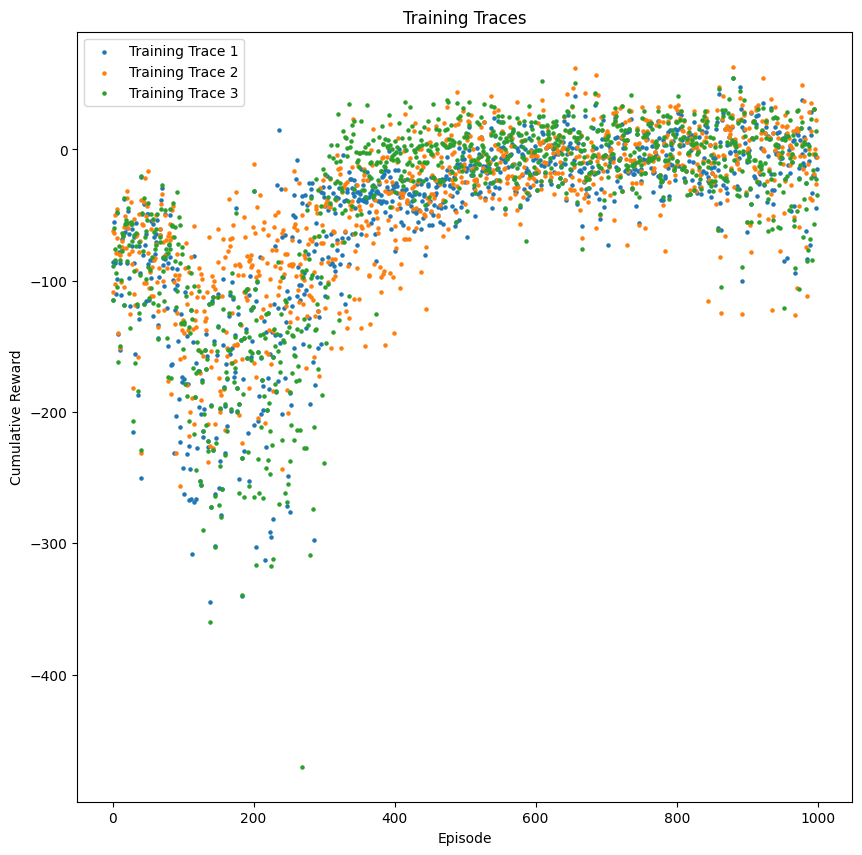

In [8]:
training_traces_scatterplot(train_traces, dots_size=5)

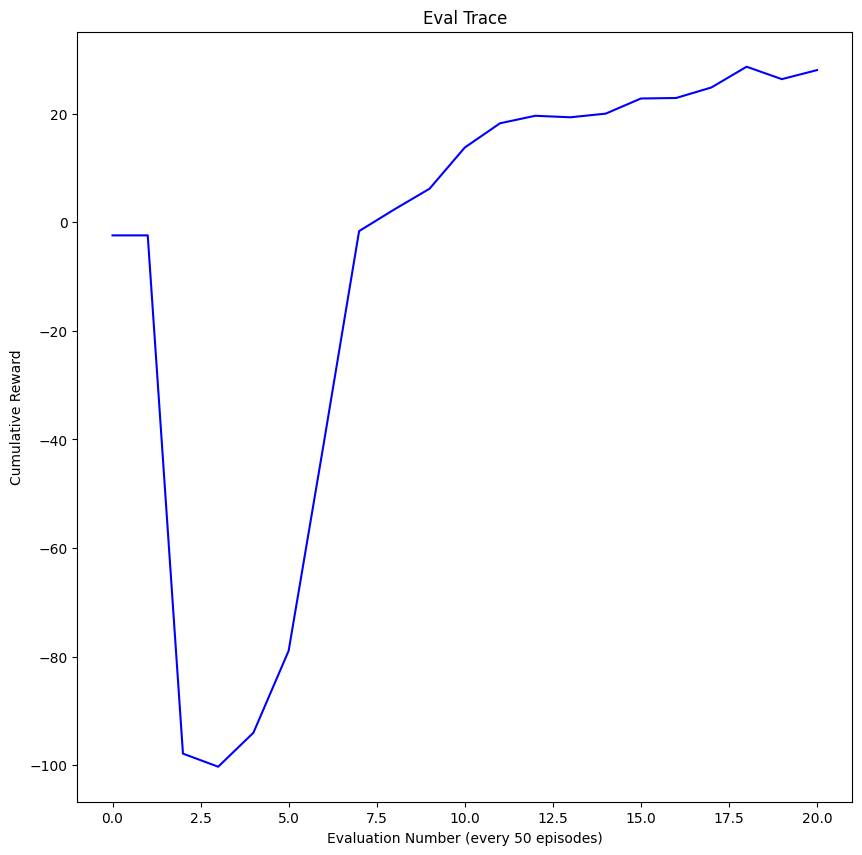

In [9]:
avg_eval_trace_lineplot(eval_traces)

**Does it successfully learn ?**  
As we can see with the training and eval trace, the agent successfully learn and get positive reward on average, which is higher than the result with toggles. We get consistency a mean reward of above 20 for the evaluation episode for the 3 agents. This suggests that agent is able to learn from the environnement. We can notice though a big drop in the eval reward in the eval trace at the beginning of training. The consistency of this immense drop suggests that something is happening at the beginning of the training. Our hypothesis is that, early in the training, the agent explores the different possible actions, some of which are not great (same as 3.b).

In [17]:
best_dqn_multiaction_agent, best_dqn_multiaction_idx = get_best_model(dqn_multiaction_agents, eval_traces)
print("The best DQN multi-action agent DQN-multiaction-{}".format(best_dqn_multiaction_idx))

The best DQN multi-action agent DQN-multiaction-2


In [23]:
logs = best_dqn_multiaction_agent.eval_model(n_episodes=3).logs
log = logs[0]

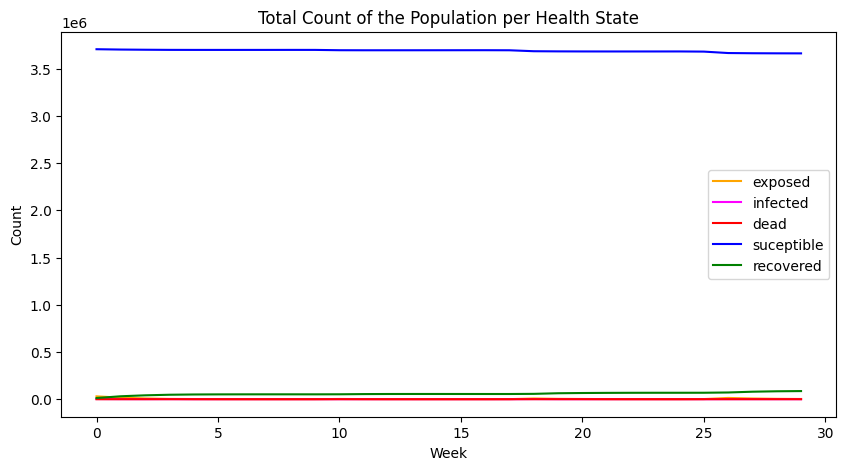

In [24]:
episode_totals_plot(log)

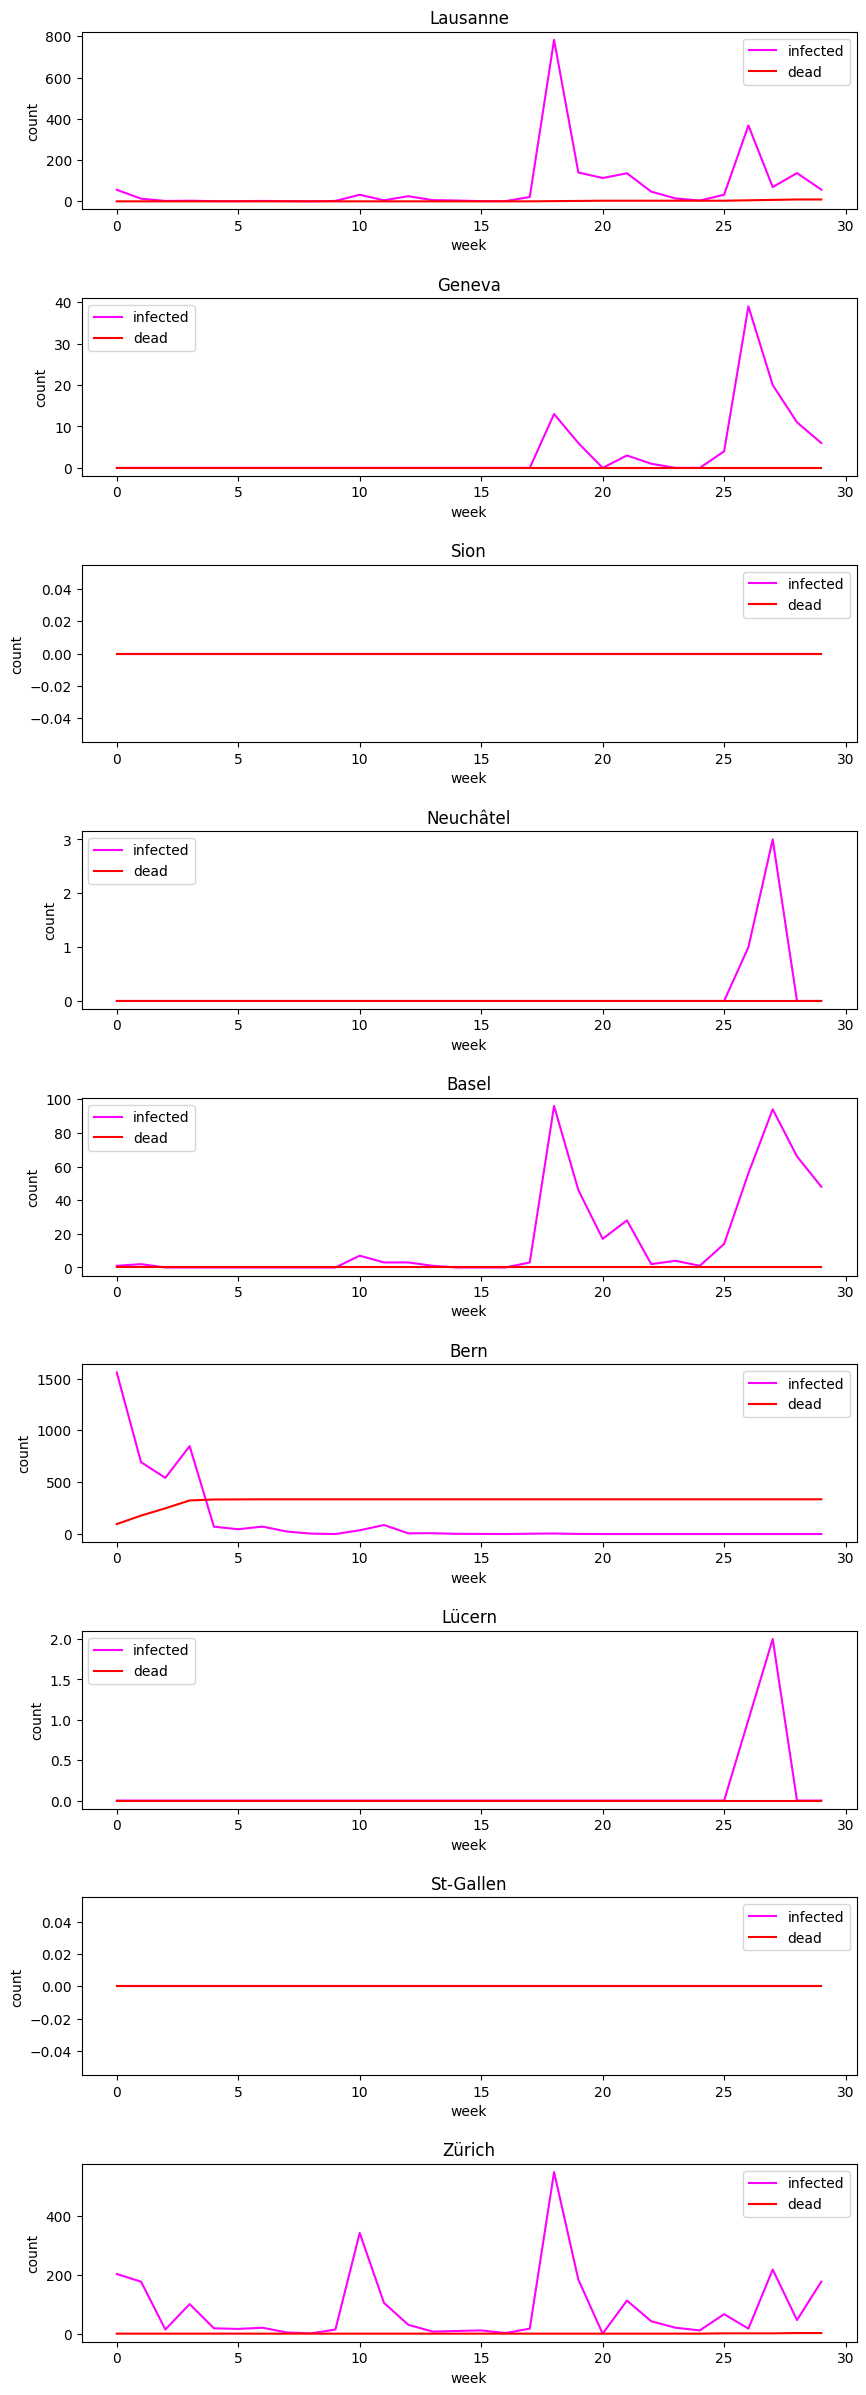

In [25]:
episode_city_totals_plot(log, health_states=["infected", "dead"], cities=dyn.cities)

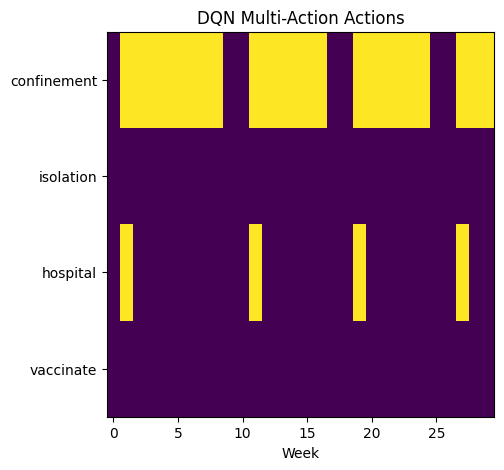

In [26]:
episode_actions_plot(log, actions=ACTIONS, title="DQN Multi-Action Actions")

**Policy interpretation**  
Interestingly, the policy strongly resembles the one obtained in part 3 with DQN (and only one action). The policy is to confine for about 5 to 10 weeks, until the number of infected is sufficiently low. Then the agent uses the confinement action again when the number of infection starts to rise again. We can observe that in the above plot, where the number of infections is almost 0 in week 8 in Zürich. The number of infected begins to rise again in week 10, and the agent decides to confine again in reaction to that surge. There seems to be a consistent pattern in terms of confinement durations, which matches the pandemics highs and lows (especially in Zürich).  
The difference with the policy in part 3 though, is the usage of the hospital action. While it's not used frequently, the agent still uses this action consistently at the beginning of the confinement phases.  
In general, the strategy found by the agent aligns with the one in part 3 (and even to the Russo policy to some extent): it's a very conservative strategy that tries to stop the spread of the virus as much as possible at the beginning of the exponential spreading phases. The total number of infected in a given city remains always very low at any given time, in particular it never goes above 1000 infected.  
Another interesting observation is that the agent never uses the `isolation` and `vaccination` action, and scarcely the `hospital` action. It seems like the agent learns quickly to favor the `confinement` action, and assigns low Q values for the other actions. This could be the result of the early phase of training that we mentioned, where the agent has tried all action and quickly drops the actions mentioned above.  

## Question 4.2.b

In [27]:
best_dqn_multiaction_eval_result = best_dqn_multiaction_agent.eval_model(n_episodes=50)

Average death number: 3846.56
Average number of confined days: 158.34
Average number of isolation days: 0.0
Average number of hospital days: 44.52
Average number of vaccination days: 0.0
Average cumulative reward: 26.89940373286605


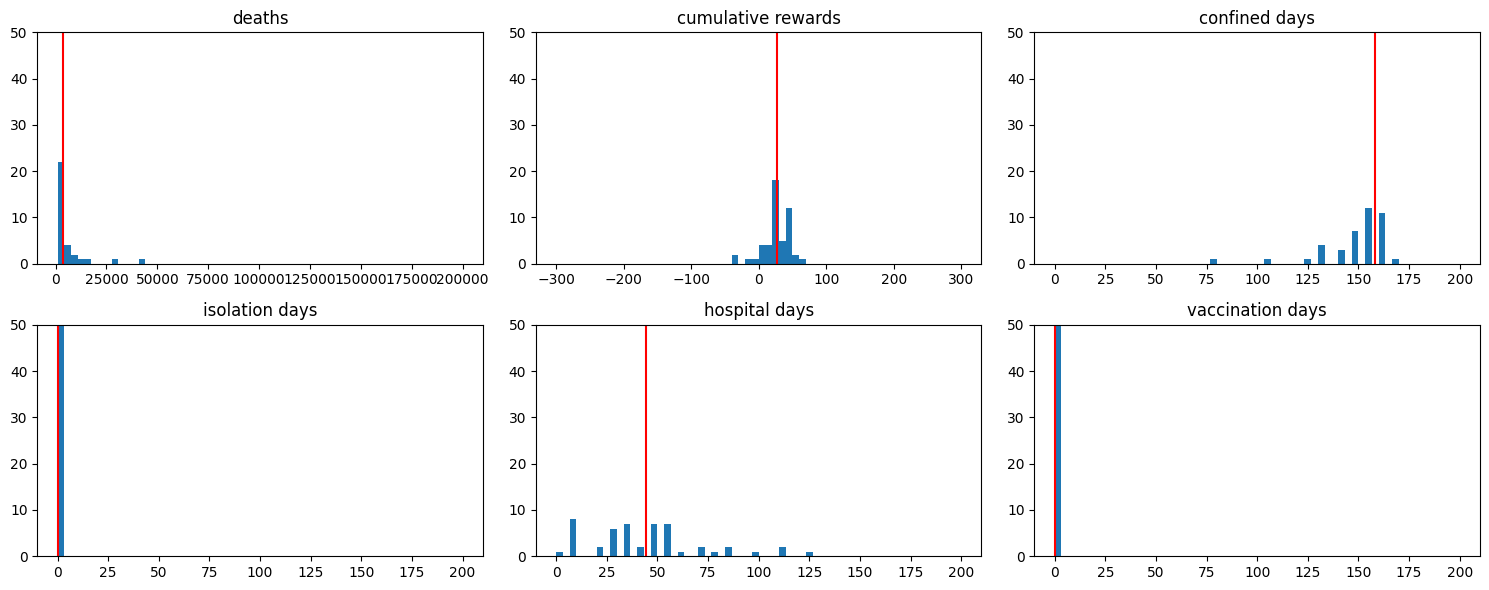

In [18]:
fig, ax = plt.subplots(2, 3,figsize=(15, 6))

hist_avg(ax[0][0], best_dqn_multiaction_eval_result.deaths,'deaths')
hist_avg(ax[0][1], best_dqn_multiaction_eval_result.cum_rewards,'cumulative rewards')
hist_avg(ax[0][2], best_dqn_multiaction_eval_result.confinement_days,'confined days')
hist_avg(ax[1][0], best_dqn_multiaction_eval_result.isolation_days,'isolation days')
hist_avg(ax[1][1], best_dqn_multiaction_eval_result.hospital_days,'hospital days')
hist_avg(ax[1][2], best_dqn_multiaction_eval_result.vaccinate_days,'vaccination days')
fig.tight_layout()

print(f'Average death number: {np.mean(best_dqn_multiaction_eval_result.deaths)}')
print(f'Average number of confined days: {np.mean(best_dqn_multiaction_eval_result.confinement_days)}')
print(f'Average number of isolation days: {np.mean(best_dqn_multiaction_eval_result.isolation_days)}')
print(f'Average number of hospital days: {np.mean(best_dqn_multiaction_eval_result.hospital_days)}')
print(f'Average number of vaccination days: {np.mean(best_dqn_multiaction_eval_result.vaccinate_days)}')
print(f'Average cumulative reward: {np.mean(best_dqn_multiaction_eval_result.cum_rewards)}')

**How does it compare to the toggled policy?**  
The average cumulative reward in 4.1.b was -76.53, which is way lower than the 26.89 obtained here. It suggests that the factorized Q-values agent is able to learn a better policy than the toggled action agent. While the average number of confinement days is high (158.34), the average number of death is very low (3846.56) compared to the toggled policy which had 76340.92 average number of death.  
Also, the factorized Q-values agent finds a policy which is more interpretable than the toggled action policy: it's a more consistent policy that uses almost exclusively the same action with a regular pattern.

## Question 4.2.c

**Assumption**  
The assumption on the action space is that, for a given state, for each possible action, doing the action may or may not be preferable to not doing the action. So the agent can choose to do an action or not without any cost for transition. Also, it assumes that we have the choice for each action to do or not to do the action. It also assumes that, any given step, the agent can choose any action or undo any action without any delay and without any additional cost.

**Action space where factorized Q-values would not be suitable?**  
Although the assumption is general and quite applicable to many situations, there are still some cases where it's not ideal or it's not feasible.

One problematic case is when the agent is limited in the number of actions it can change at the same time, this technic would probably not work well. Another case, is when doing or undoing an action induces an extra cost for the transition. This is specifically the kind of assumption under which the strategy in part 4.1 is more suitable. Another case is when doing or undoing an action may take time and does not happen instantly, which would break the above mentioned assumptions.

Overall, although this strategy works well, the assumptions needed may make this strategy not realistic in the case of handling an epidemic. Indeed, governments would not be able to change their policy radically almost instantly at any given time, and there would definitely be a delay between the decisions and the application of the decision.

  

# PART 5

**Question 5.a**

**note: Russo policy doesn't have a training or evaluation curve.**

- Training curves: Exploratory decay and factorized Q-values models have a somewhat similar training curve whe the model performs badly in the first episodes where exploration is high, then they converge to a much better policy since the training curve is rather on the positive half of the reward measurement. The toggle-action space model's training curve looks very random. Although there is slight improvement during training, it is hardly noticeable on the training scatter plot. The model does not seem to converge and the final policy performs poorly. 

- Evaluation curves: With exploratory decay and factorized Q-values modelss, we have an evaluation curve that decreases initially perhaps due to high exploration, then it increases and fluctuates around a mean evaluation reward perhaps indicating convergence. We have something similar with the toggle-action space model but the best evaluation trace is still far below that of the two previous models.

- Performance: From our previous analysis on cumulative reward on 50 simulated episodes for the best policy of each model, we can order the models by performance in the following way: Binary action > factorized Q-values > Russo > toggle-action space

- Best approach: according to the ordering by performance hereabove, binary action model is the best.

**Question 5.b**

In [4]:
######################
# environements
######################

######################
# env 2
######################

env2 = Env(dyn,
           action_preprocessor=russo_acton_preprocessor, 
           observation_preprocessor=russo_observation_preprocessor)

######################
# env 3
######################

action_space      = spaces.Discrete(2) # [0, 1]
observation_space = spaces.Box(low=0, high=1,
                               shape=(2, dyn.n_cities, dyn.env_step_length),
                               dtype=np.float16)

env3 = Env(dyn,
           action_space=action_space,
           observation_space=observation_space,
           action_preprocessor=dqn_action_preprocessor,
           observation_preprocessor=dqn_observation_preprocessor)

######################
# env 4
######################

multiaction_action_space = spaces.Discrete(len(TOGGLE_ACTIONS))
multiaction_observation_space = spaces.Dict({
    "observation": spaces.Box(low=0, high=1, shape=(2, dyn.n_cities, dyn.env_step_length), dtype=np.float16),
    "action": spaces.Discrete(len(TOGGLE_ACTIONS) - 1)
    })

env4 = Env(dyn,
           observation_space=multiaction_observation_space,
           action_space=multiaction_action_space,
           observation_preprocessor=toggleaction_dqn_observation_preprocessor,
           action_preprocessor=toggleaction_dqn_action_preprocessor)

######################
# env 5
######################

action_space      = spaces.Discrete(4)
observation_space = spaces.Box(low=0, high=1,
                               shape=(2, dyn.n_cities, dyn.env_step_length),
                               dtype=np.float16)

env5 = Env(dyn,
           action_space=action_space,
           observation_space=observation_space,
           action_preprocessor=multiaction_dqn_factorized_qvals_action_preprocessor,
           observation_preprocessor=dqn_observation_preprocessor)

In [5]:
basepath = "./train/"

best_singleaction_agent_path = basepath + "DQN-base-1.pt"
best_toggleaction_agent_path = basepath + "DQN-toggleaction-1.pt"
best_multiaction_agent_path  = basepath + "DQN-multiaction-Q-factorized-2.pt"

russo_agent = RussoAgent(env2, confinement_duration=4)
best_singleaction_agent = DQNAgent(env3, lr=5e-3)
best_singleaction_agent.load_model(best_singleaction_agent_path)
best_toggleaction_agent = DQNAgentWithExplorationDecay(env4, lr=1e-5)
best_toggleaction_agent.load_model(best_toggleaction_agent_path)
best_multiaction_agent  = DQNAgentWithFactorizedQvals(env5, lr=1e-5)
best_multiaction_agent.load_model(best_multiaction_agent_path)

In [15]:
eval_results = {
    "Russo": russo_agent.eval_model(n_episodes=50),
    "Single Action DQN": best_singleaction_agent.eval_model(n_episodes=50),
    "Toggle Action DQN": best_toggleaction_agent.eval_model(n_episodes=50),
    "Multi-Action DQN": best_multiaction_agent.eval_model(n_episodes=50)
}

In [17]:
import pandas as pd

results_df = pd.DataFrame(columns= ["agent", "avg_deaths", "avg_cum_rew", "avg_conf_days", "avg_isol_days", "avg_hosp_days", "avg_vacc_days"])

results = []
for agent_name, eval_result in eval_results.items():
    results.append({
            "agent": agent_name,
            "avg_deaths": eval_result.deaths.mean(),
            "avg_cum_rew": eval_result.cum_rewards.mean(),
            "avg_conf_days": eval_result.confinement_days.mean(),
            "avg_isol_days": eval_result.isolation_days.mean(),
            "avg_hosp_days": eval_result.hospital_days.mean(),
            "avg_vacc_days": eval_result.vaccinate_days.mean()
         })
results_df_ext = pd.DataFrame(results)
results_df = pd.concat([results_df, results_df_ext], ignore_index=True)
    
results_df

,agent,avg_deaths,avg_cum_rew,avg_conf_days,avg_isol_days,avg_hosp_days,avg_vacc_days
0,Russo,55443.66,-62.120918,103.32,0.0,0.00,0.00
1,Single Action DQN,1942.84,49.822689,163.10,0.0,0.00,0.00
2,Toggle Action DQN,76631.88,-44.351991,0.00,0.0,109.48,128.66
3,Multi-Action DQN,783.80,37.853908,180.32,0.0,19.32,0.00


In [20]:
evaluated_agents_per_metric = {
    "avg_deaths": ["Russo", "Single Action DQN", "Toggle Action DQN", "Multi-Action DQN"],
    "avg_cum_rew": ["Russo", "Single Action DQN", "Toggle Action DQN", "Multi-Action DQN"],
    "avg_conf_days": ["Russo", "Single Action DQN", "Toggle Action DQN", "Multi-Action DQN"],
    "avg_hosp_days": ["Toggle Action DQN", "Multi-Action DQN"],
    "avg_vacc_days": ["Toggle Action DQN", "Multi-Action DQN"],
    "avg_isol_days": ["Toggle Action DQN", "Multi-Action DQN"]
}

# binary encoding for each metric, 1 if the best is argmax, 0 if it is argmin
metric_min_max = {"avg_deaths": 0, "avg_cum_rew": 1, "avg_conf_days": 0, "avg_hosp_days": 0, "avg_vacc_days": 0, "avg_isol_days": 0}

for metric in results_df.columns[1:]:
    evaluated_agents = set(evaluated_agents_per_metric[metric])
    df = results_df.query("agent in @evaluated_agents")
    best_model_idx = df[metric].argmax() if metric_min_max[metric] else df[metric].argmin()
    print(f"{metric}: the best model is {df.iloc[best_model_idx]['agent']}")

avg_deaths: the best model is Multi-Action DQN
avg_cum_rew: the best model is Single Action DQN
avg_conf_days: the best model is Toggle Action DQN
avg_isol_days: the best model is Toggle Action DQN
avg_hosp_days: the best model is Multi-Action DQN
avg_vacc_days: the best model is Multi-Action DQN


**Discussion**  
The best policy in terms of the average reward metric is the single action DQN. Even if the average number of deaths is higher than the multi-action DQN with factorized Q-values, the average number of confinement days is lower for the single action policy, and this policy doesn't use any other action compared to the multi-action DQN. For these two reasons, the average reward is higher for the single action DQN.While having a lower average reward, the best multi-action DQN with factorized Q-values performs almost as good as the best single action DQN. The average number of death is lower with this policy, but it takes more actions on average across episodes.

Overall, there is a substantial gap between these two models, and the other two (Russo and toggled-action). The Russo policy and the policy of the best toggle action DQN give both a negative average reward (-62.120918, -44.351991), and their average number of deaths is also way higher. This shows also that the policy of the trained DQN agents heavily outperforms the heuristics-based baseline Russo policy.

**Question 5.c**

In [6]:
eval_result = best_singleaction_agent.eval_model(n_episodes=1, compute_qvals=True)

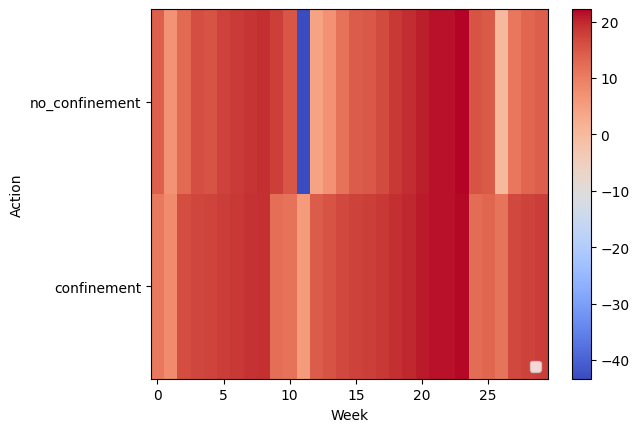

In [9]:
# heatmap of q-values for dqn
q_values = eval_result.q_values
action_dict = {0: "no_confinement", 1: "confinement"}
show_qvals_heatmap(q_values, action_dict)

**Discuss your results. How interpretable is your policy?**  
We see from the heatmap that the Q_values for both `confinement` and `no_confinement` remain high on average. However, the confinement action q value is a bit higher between weeks 2 to 7, 12 to 23 and 27 to 30. It seems like it correspond to high number of infections. We then see that between those intervals, the q value for confinement is lower, and the q value for no_confinement exceed confinement.  
A plausible explanation for the q value of confinement going down during those intervals is that the number of infections becomes way lower, which makes sense since it would not be useful to confine in that case.

In [11]:
# reload training results of best agent in 4.2
best_factorized_agent_idx = 2
best_multiaction_agent_path ="./train/DQN-multiaction-Q-factorized-{}.pt".format(best_factorized_agent_idx)
best_dqn_multiaction_agent = DQNAgentWithFactorizedQvals(env5)
best_dqn_multiaction_agent.load_model(best_multiaction_agent_path)
eval_result = best_dqn_multiaction_agent.eval_model(n_episodes=1, compute_qvals=True)

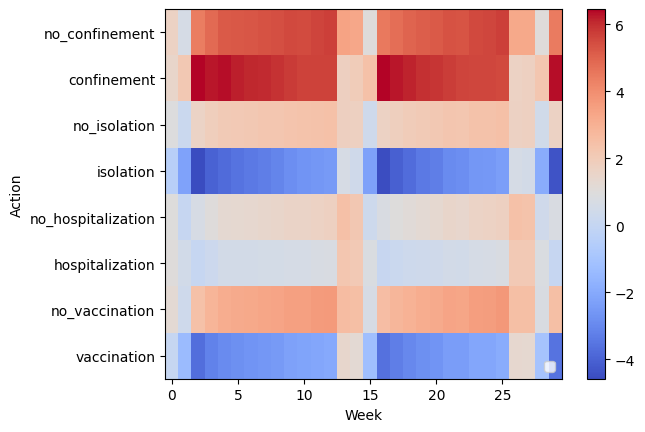

In [16]:
# heatmap of q-values for factorized dqn
q_values = eval_result.q_values
action_dict = {0: "no_confinement", 1: "confinement", 2: "no_isolation", 3: "isolation", 4: "no_hospitalization", 5: "hospitalization", 6: "no_vaccination", 7: "vaccination"}
show_qvals_heatmap(q_values, action_dict)

**Discuss your results. How interpretable is your policy?**
The Q_values heatmap follow closely the plausible explanation given above for the interpretation of the policies: the Q values for the confinement action is high when the number of infect is high, then it decreases when the number of infections is low. Overall, both `no_confinement` and `confinement` have an high Q_value (except at specific states). On the other hand, for all other actions, the no_actions have much higher Q value than the actions. However, there are still specif intervals where the difference between no_action and action is small, which seems to correspond to when there is a small number of infection. This explains, that the agent chooses to use the `hospitalization` actions sometimes.  
The confinement/no_confinement choices are interpretable, but the `hospitalization` action is a bit less. However, we see that even if the agent sometimes uses the `hospitalization` action, the Q value for that action compared to not doing it remains fairly low, which means that it's not a very valuable action still.

Question 5.d

No, cumulative reward is not necessarily an increasing function in the number of actions because single-action approach has a best model with a higher cumulative reward than that of the best model following the factorized Q-values approach which has more actions.